# Graph File Pre-Processing

In [1]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle
import networkx as nx


In [4]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot
import torch

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle


# ------------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------------

# Take ROOT file and convert to an awkward array
def fileToAwk(path):
    file = uproot.open(path)
    tree = file['tree']
    awk = tree.arrays(tree.keys())
    return awk

# Features used to train the model
input_features = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi", "part_d0val", "part_d0err",
    "part_dzval", "part_dzerr", "part_isChargedHadron", "part_isNeutralHadron",
    "part_isPhoton", "part_isElectron", "part_isMuon"
]

# Take AWK dict and convert to a point cloud
def awkToPointCloud(awkDict, input_features):
    featureVector = []
    for jet in tqdm(range(len(awkDict)), total=len(awkDict)):
        currJet = awkDict[jet][input_features]
        try:
            pT = np.sqrt(ak.to_numpy(currJet['part_px']) ** 2 + ak.to_numpy(currJet['part_py']) ** 2)
            # Create numpy array to represent the 4-momenta of all particles in a jet
            currJet = np.column_stack((
                ak.to_numpy(currJet['part_px']),
                ak.to_numpy(currJet['part_py']),
                ak.to_numpy(currJet['part_pz']),
                ak.to_numpy(currJet['part_energy']),
                pT,
                ak.to_numpy(currJet['part_deta']),
                ak.to_numpy(currJet['part_dphi']),
                ak.to_numpy(currJet["part_d0val"]),
                ak.to_numpy(currJet["part_d0err"]),
                ak.to_numpy(currJet["part_dzval"]),
                ak.to_numpy(currJet["part_dzerr"]),
                ak.to_numpy(currJet["part_isChargedHadron"]),
                ak.to_numpy(currJet["part_isNeutralHadron"]),
                ak.to_numpy(currJet["part_isPhoton"]),
                ak.to_numpy(currJet["part_isElectron"]),
                ak.to_numpy(currJet["part_isMuon"])
            ))
            featureVector.append(currJet)
        except Exception as e:
            print(f"Error processing jet {jet}: {e}")
            featureVector.append(np.empty((0, len(input_features) + 1)))  # Add an empty array for failed jets
    return featureVector  # Return a list of arrays instead of a single numpy array

# Build a KNN graph from a point cloud
def buildKNNGraph(points, k):
    tree = cKDTree(points)
    dists, indices = tree.query(points, k+1)  # +1 to exclude self

    num_points = len(points)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in indices[i, 1:]:  # exclude self
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1
    return adj_matrix

# Convert adjacency matrix to a DGL graph
def adjacencyToDGL(adj_matrix):
    adj_matrix = sp.coo_matrix(adj_matrix)
    g_dgl = dgl.from_scipy(adj_matrix)
    return g_dgl

# Wrap the functionality of fileToAwk and awkToPointCloud into a single function
def fileToPointCloudArray(jetType, input_features):
    filepath = f'./data/JetClass/JetRoots/JetClass_example_100k.root'  # original ROOT file
    savepath = f'./data/JetClass/PointClouds/{jetType}.npy'   # save file
    awk = fileToAwk(filepath)
    nparr = awkToPointCloud(awk, input_features)
    return nparr

# Combine all steps: read file → build adjacency → build DGL graph → optionally save
def fileToGraph(jetType, k=3, save=True):
    print(f'Starting processing on {jetType} jets')
    pointCloudArr = fileToPointCloudArray(jetType, input_features)
    saveFilePath = f'./data/Multi Level Jet Tagging/{jetType}.pkl'

    savedGraphs = []
    for idx, pointCloud in tqdm(enumerate(pointCloudArr), leave=False, total=len(pointCloudArr)):
        try:
            adj_matrix = buildKNNGraph(pointCloud, k)
            graph = adjacencyToDGL(adj_matrix)
            graph.ndata['feat'] = torch.tensor(pointCloud, dtype=torch.float32)
            savedGraphs.append(graph)

            # Cleanup
            del adj_matrix, graph
        except Exception as e:
            print(e)

    if save:
        with open(saveFilePath, 'wb') as f:
            pickle.dump(savedGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)

        del pointCloudArr, savedGraphs

    print(f'Graphs for {jetType} processing complete!')
    return savedGraphs

def groupToGraph(jetTypeList, groupName):
    allGraphs = []
    for jetType in jetTypeList:
        allGraphs += fileToGraph(jetType, save=False)

    saveFilePath = f'./data/Multi Level Jet Tagging/{groupName}.pkl'
    with open(saveFilePath, 'wb') as f:
        pickle.dump(allGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)
    return allGraphs

# ------------------------------------------------------------------
# MAIN EXECUTION (Process All Groups)
# ------------------------------------------------------------------

Higgs = ['HToBB', 'HToCC', 'HToGG', 'HToWW2Q1L', 'HToWW4Q']
Vector = ['WToQQ', 'ZToQQ']
Top = ['TTBar', 'TTBarLep']
QCD = ['ZJetsToNuNu']
Emitter = ['Emitter-Vector', 'Emitter-Top', 'Emitter-Higgs', 'Emitter-QCD']

allGraphs_Higgs = groupToGraph(Higgs, "Emitter-Higgs")
allGraphs_Vector = groupToGraph(Vector, "Emitter-Vector")
allGraphs_Top = groupToGraph(Top, "Emitter-Top")
allGraphs_QCD = groupToGraph(QCD, "Emitter-QCD")

print("Processing of all jet groups is complete. All grouped graphs have been saved.")


Starting processing on HToBB jets


 31%|███▏      | 31424/100000 [00:10<00:20, 3273.96it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34914/100000 [00:11<00:18, 3489.00it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57064/100000 [00:18<00:12, 3522.14it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToBB processing complete!
Starting processing on HToCC jets


 31%|███▏      | 31364/100000 [00:10<00:20, 3297.03it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34866/100000 [00:11<00:18, 3508.54it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56854/100000 [00:19<00:12, 3517.17it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToCC processing complete!
Starting processing on HToGG jets


 31%|███▏      | 31347/100000 [00:11<00:21, 3213.68it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34770/100000 [00:12<00:19, 3412.67it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57146/100000 [00:19<00:12, 3449.47it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToGG processing complete!
Starting processing on HToWW2Q1L jets


 31%|███▏      | 31316/100000 [00:10<00:21, 3217.72it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34768/100000 [00:12<00:21, 3024.13it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56889/100000 [00:19<00:12, 3428.57it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW2Q1L processing complete!
Starting processing on HToWW4Q jets


 31%|███       | 31121/100000 [00:11<00:22, 3124.75it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34781/100000 [00:12<00:19, 3323.24it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57107/100000 [00:20<00:12, 3351.50it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW4Q processing complete!
Starting processing on WToQQ jets


 31%|███       | 31129/100000 [00:10<00:21, 3137.18it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34801/100000 [00:11<00:19, 3351.37it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56999/100000 [00:19<00:12, 3385.85it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for WToQQ processing complete!
Starting processing on ZToQQ jets


 31%|███▏      | 31319/100000 [00:10<00:22, 3068.00it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34744/100000 [00:11<00:19, 3347.83it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56908/100000 [00:18<00:12, 3361.97it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for ZToQQ processing complete!
Starting processing on TTBar jets


 31%|███       | 31208/100000 [00:10<00:21, 3147.87it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34976/100000 [00:11<00:19, 3415.43it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 57059/100000 [00:18<00:12, 3500.28it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for TTBar processing complete!
Starting processing on TTBarLep jets


 31%|███▏      | 31437/100000 [00:10<00:20, 3271.33it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34855/100000 [00:11<00:19, 3423.48it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56968/100000 [00:18<00:12, 3451.37it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for TTBarLep processing complete!
Starting processing on ZJetsToNuNu jets


 31%|███       | 31198/100000 [00:10<00:21, 3202.52it/s]

index 3 is out of bounds for axis 1 with size 3


 35%|███▍      | 34987/100000 [00:11<00:18, 3440.71it/s]

index 3 is out of bounds for axis 1 with size 3


 57%|█████▋    | 56985/100000 [00:18<00:12, 3423.05it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for ZJetsToNuNu processing complete!
Processing of all jet groups is complete. All grouped graphs have been saved.


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Higgs file loaded successfully! Total number of graphs: 499985


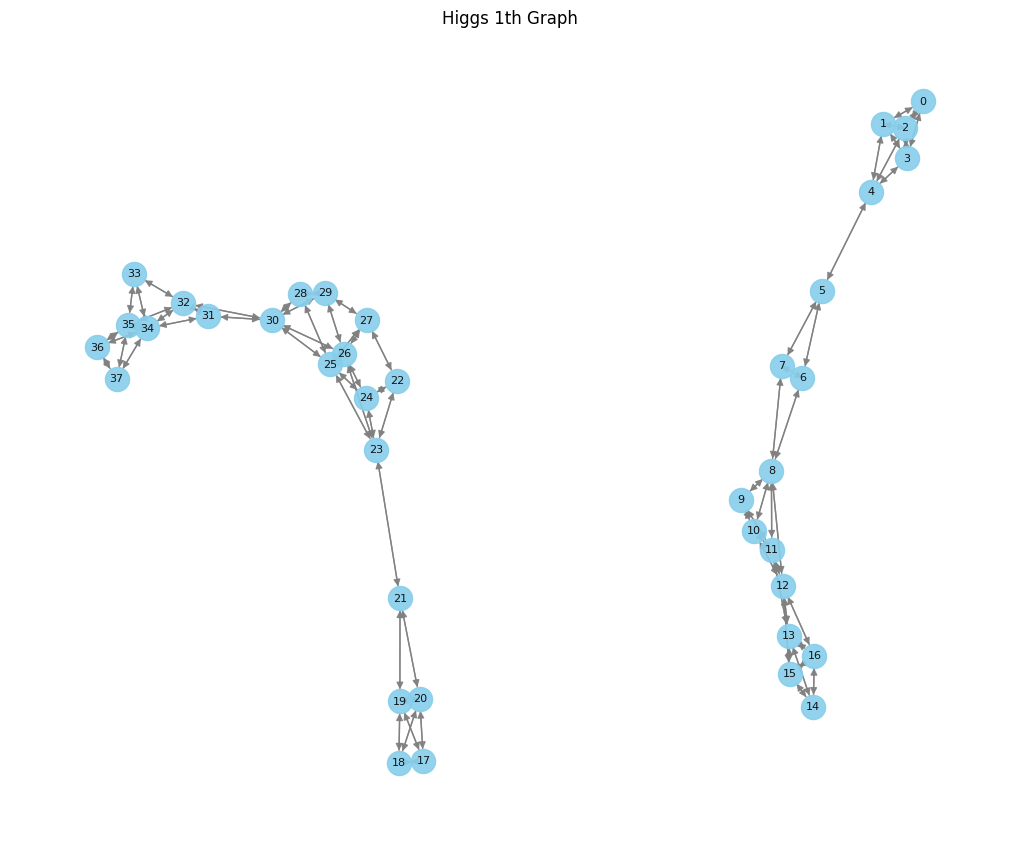

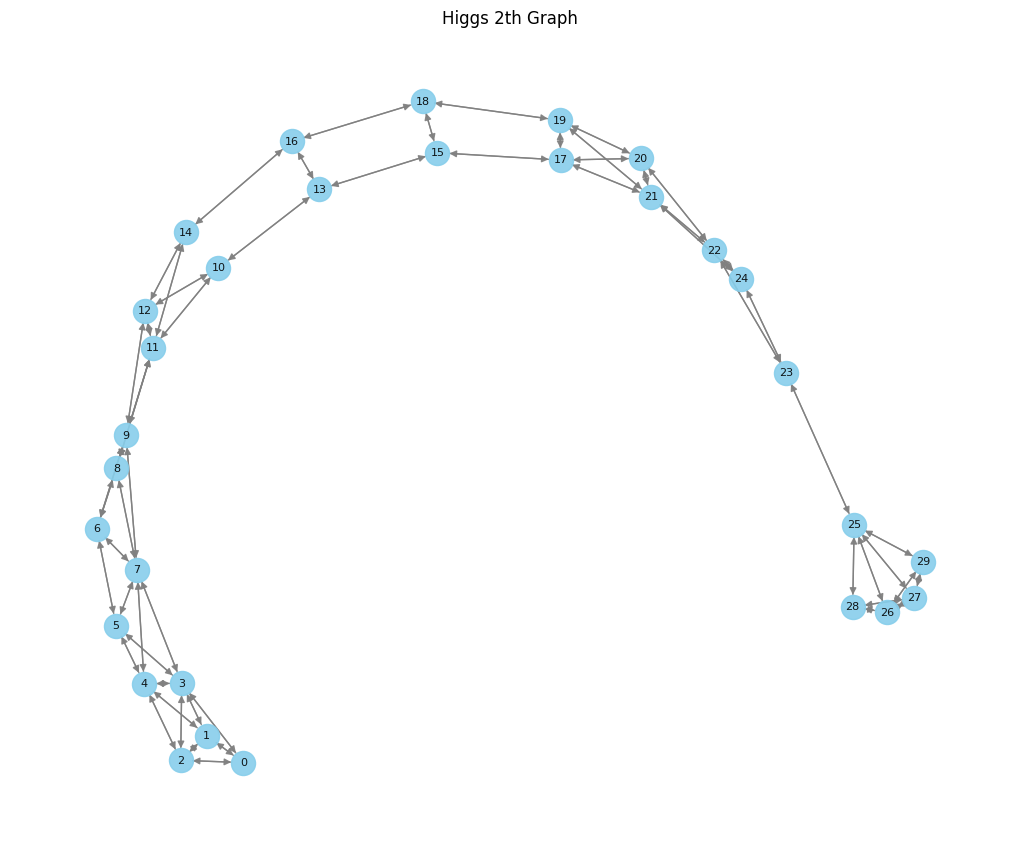

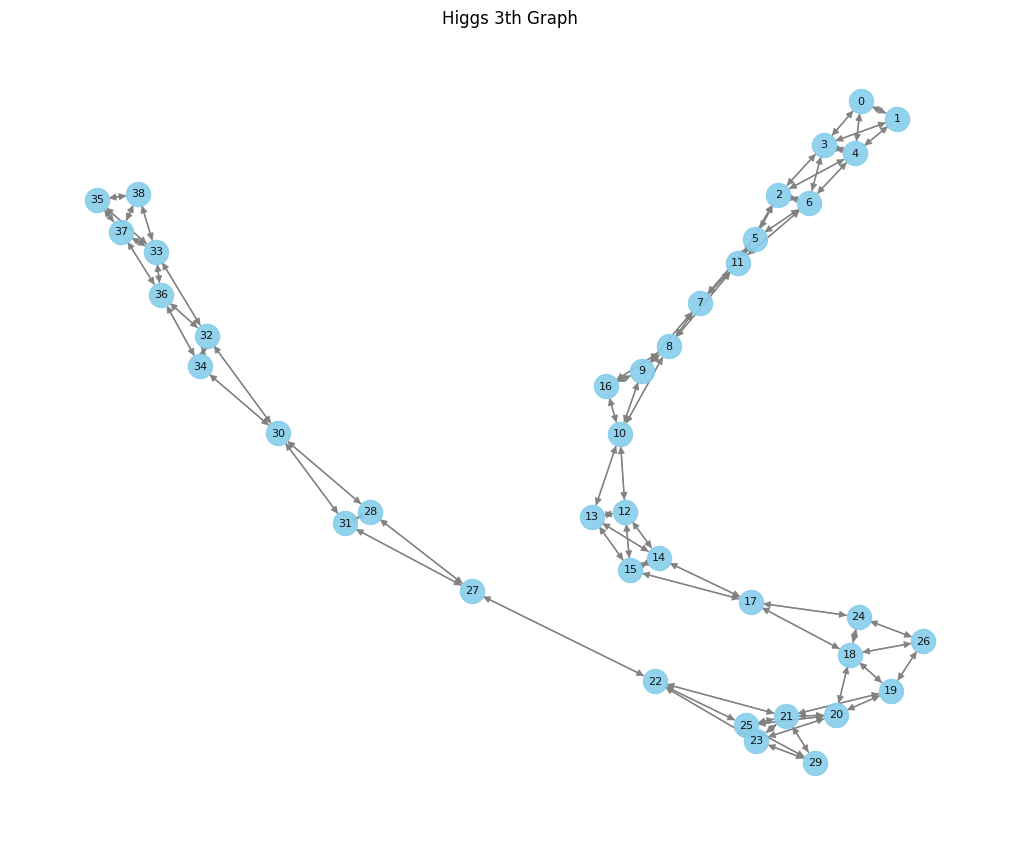

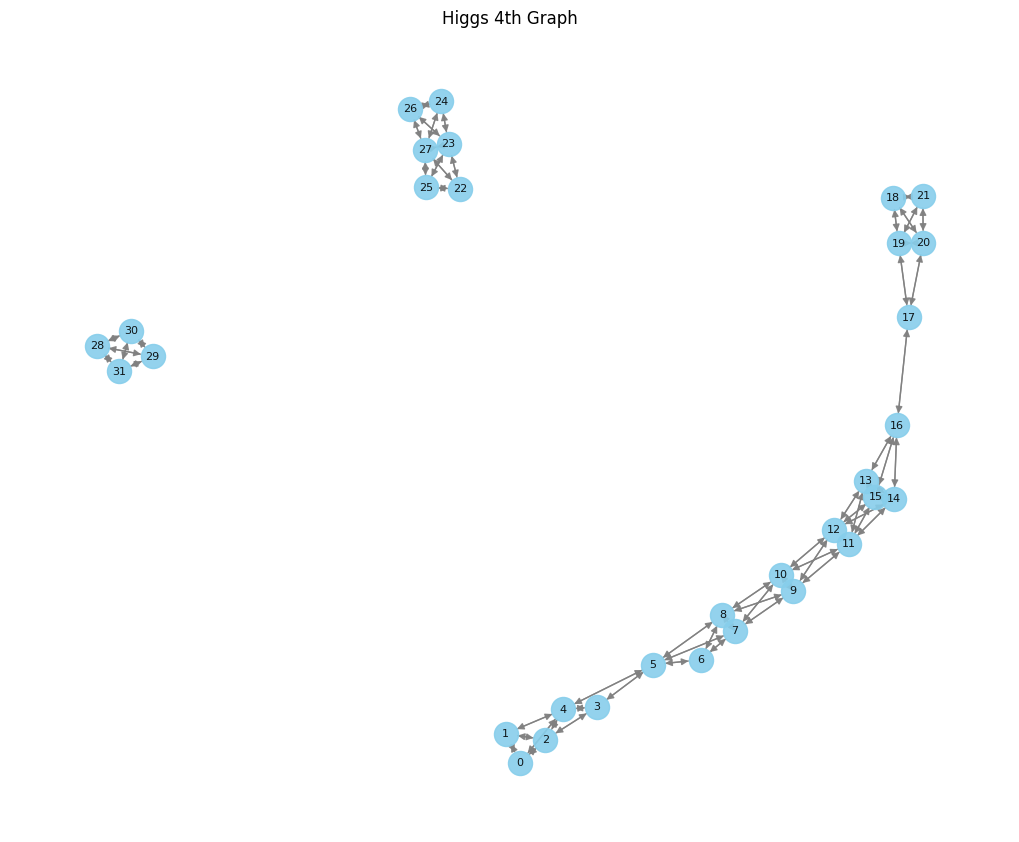

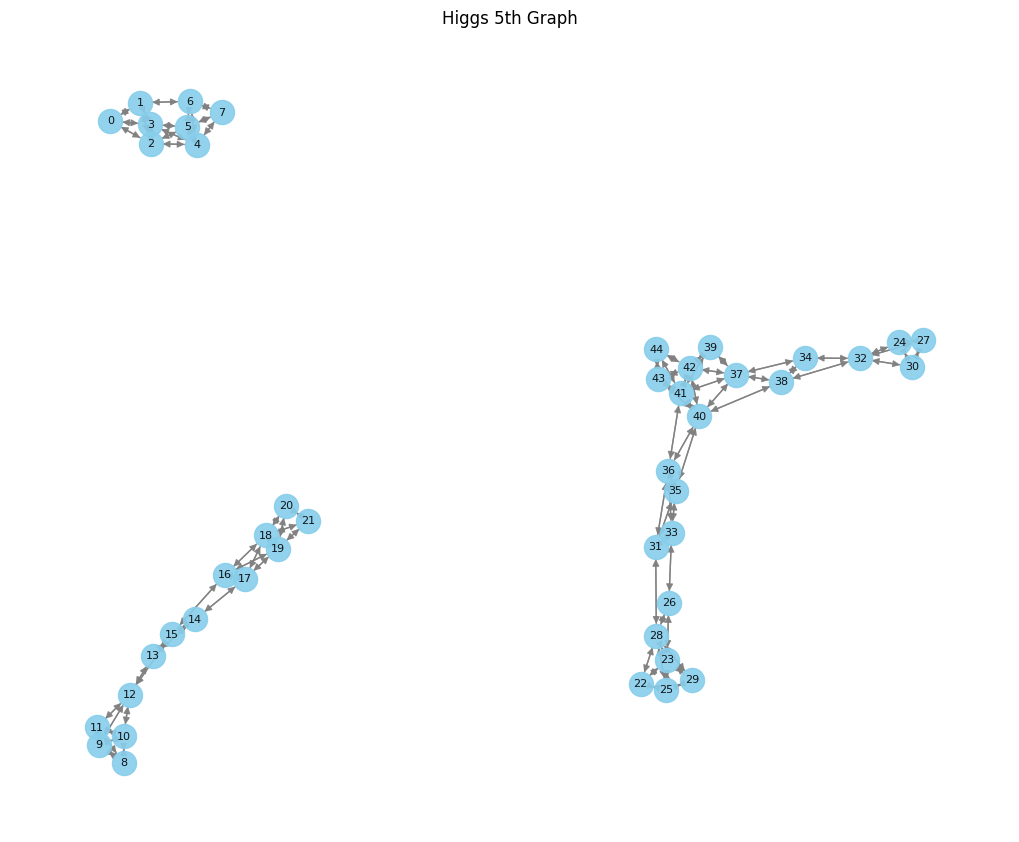

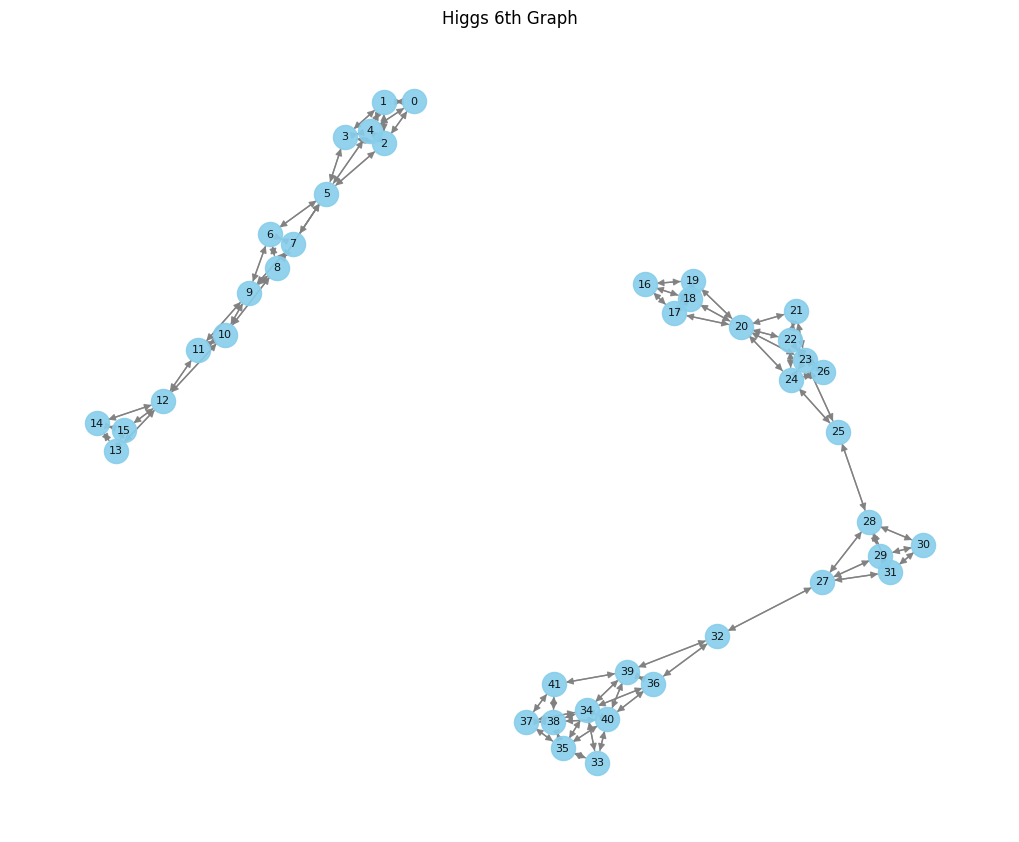

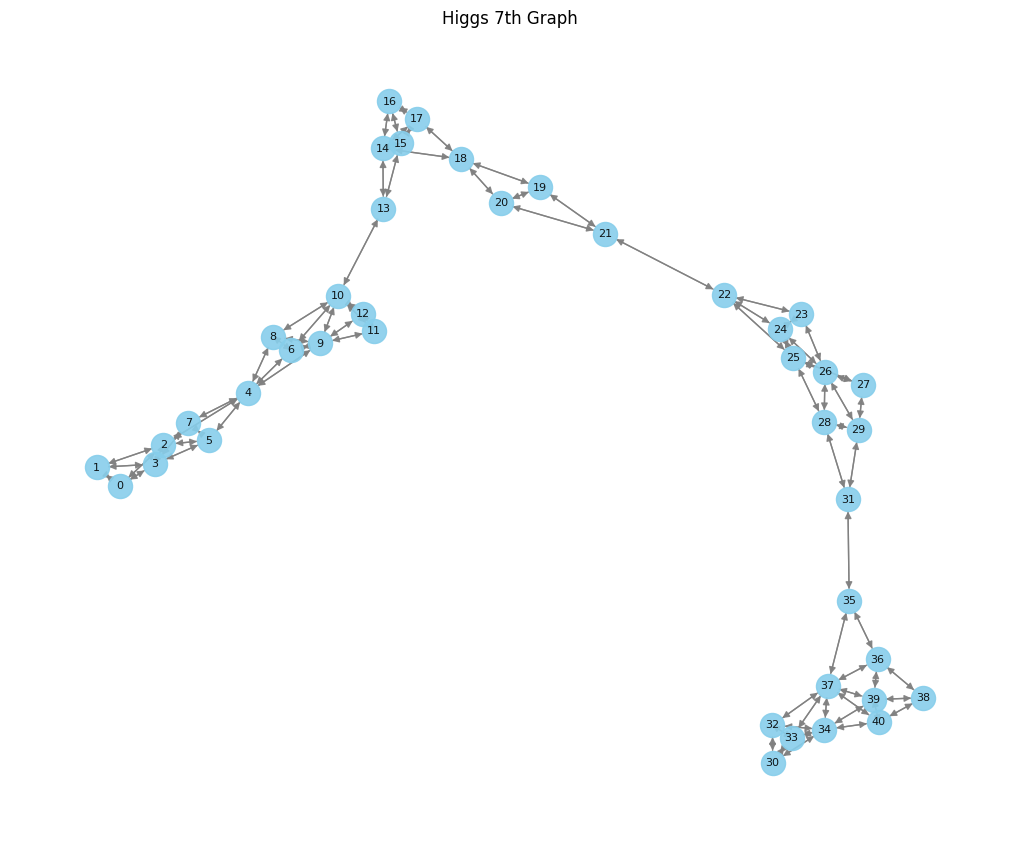

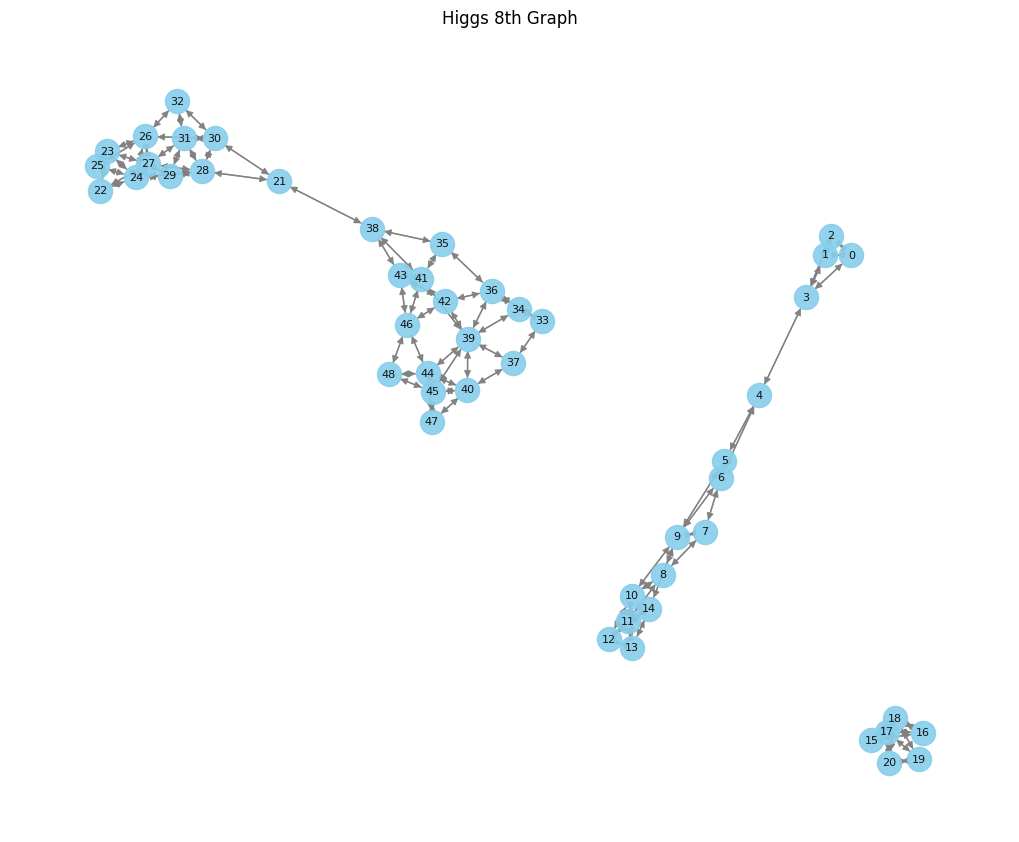

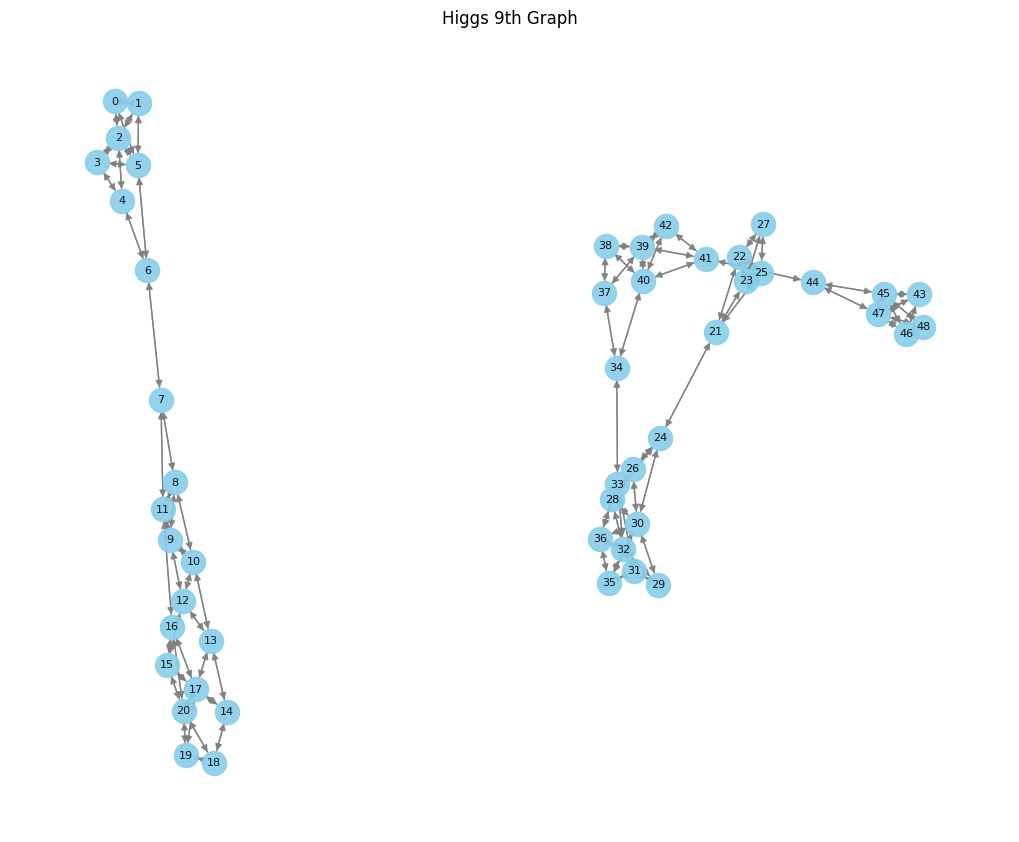

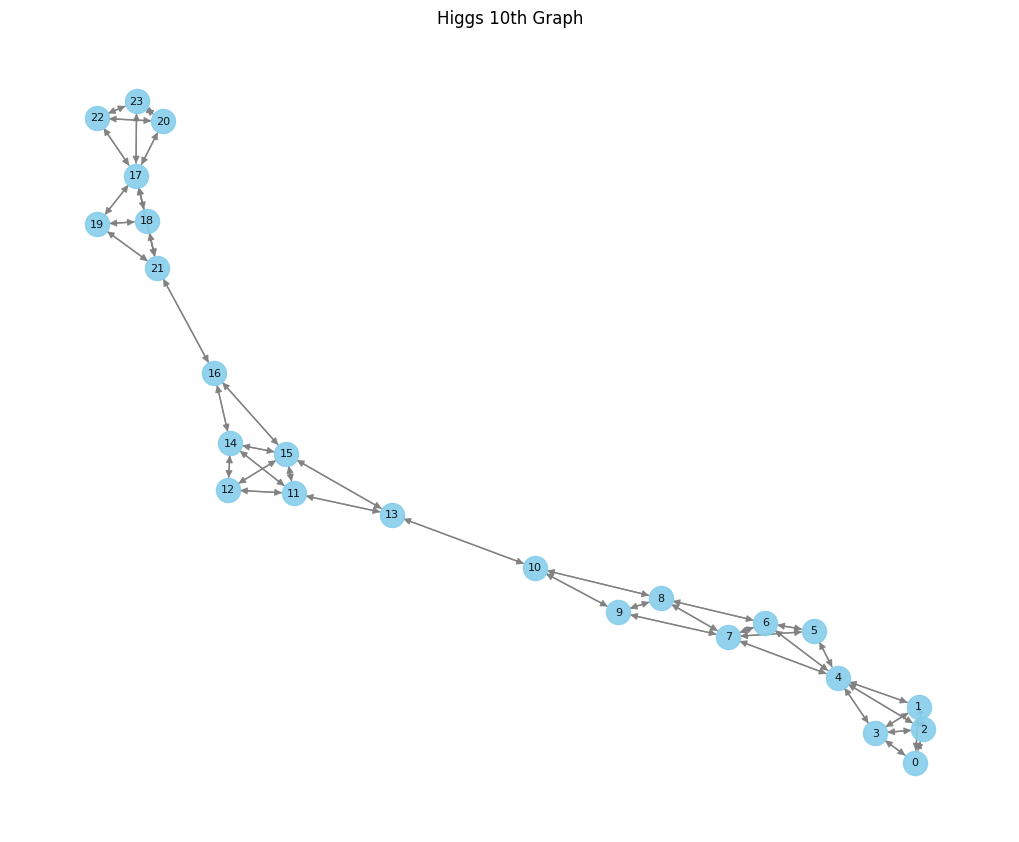

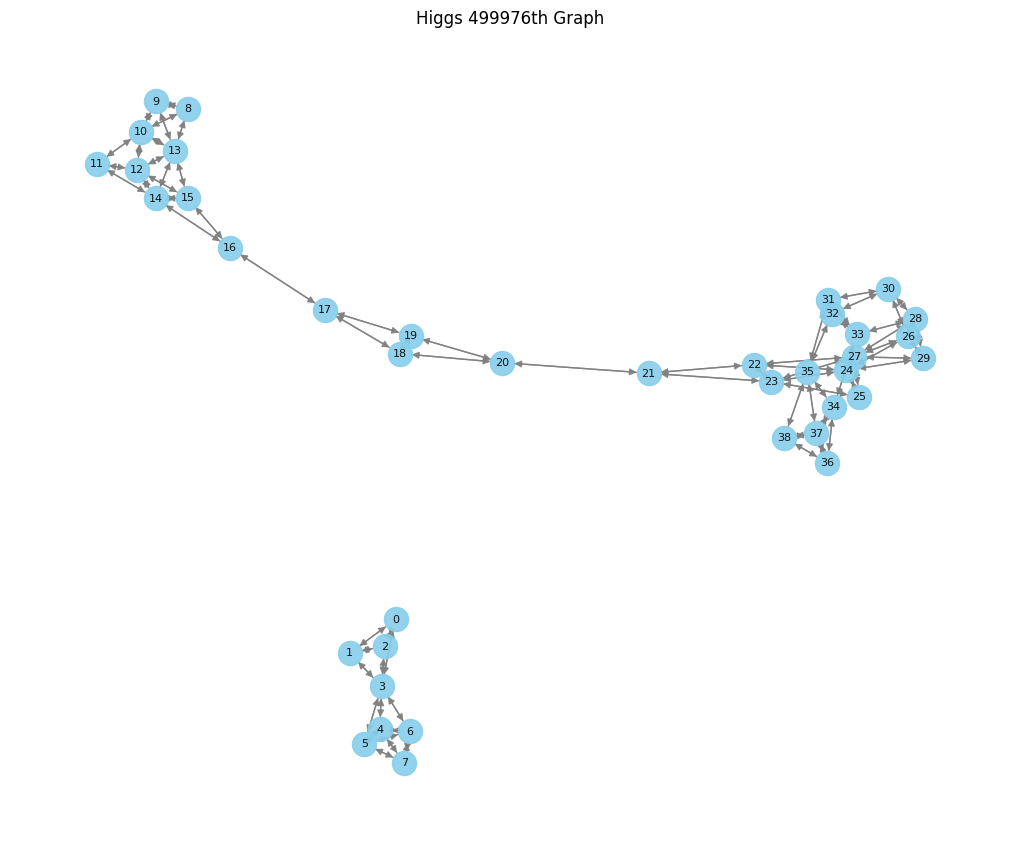

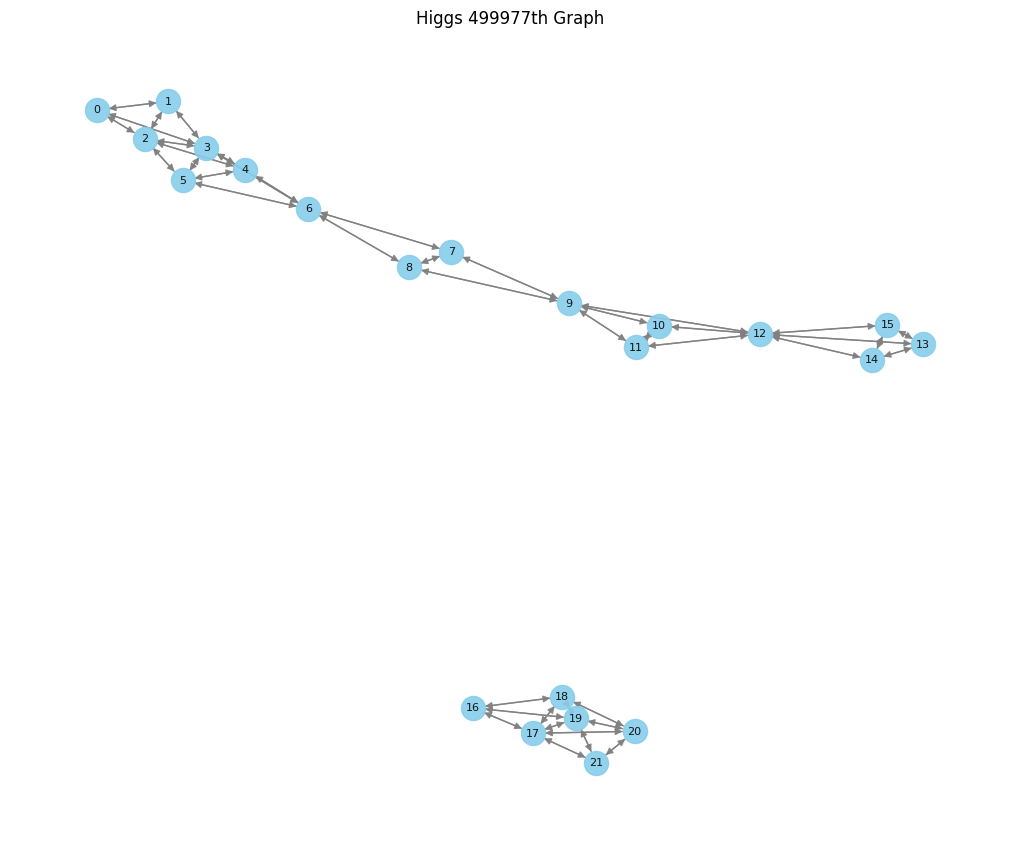

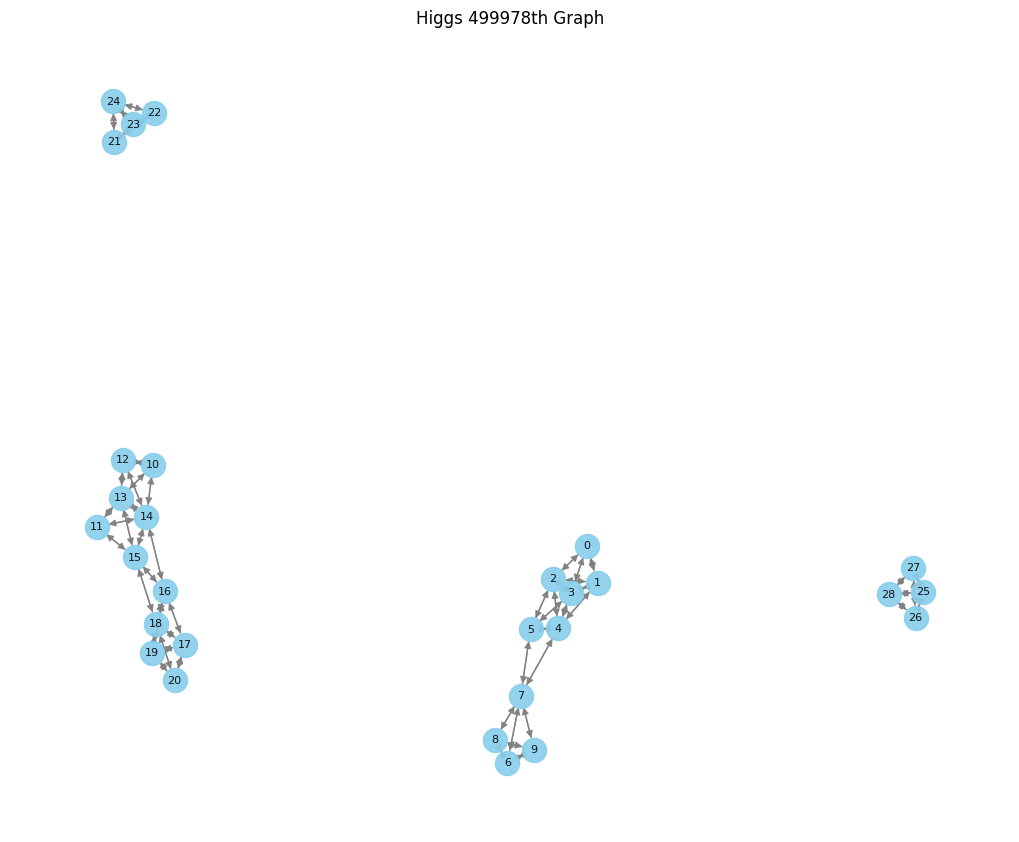

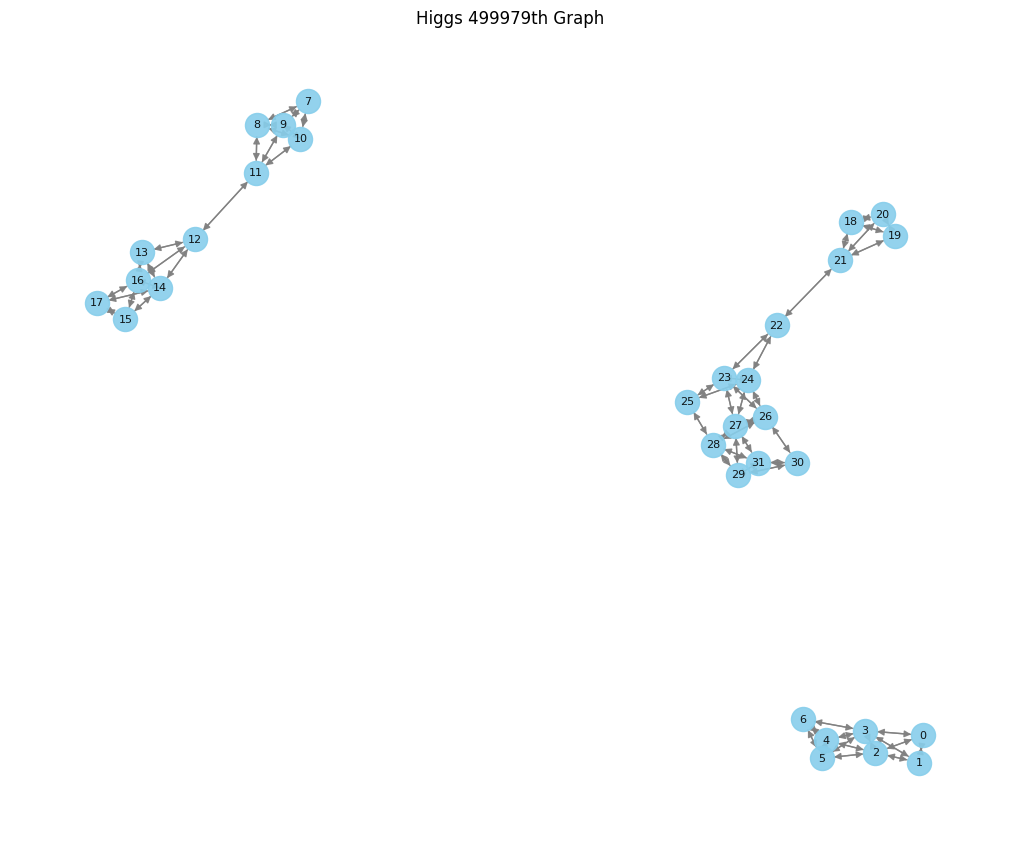

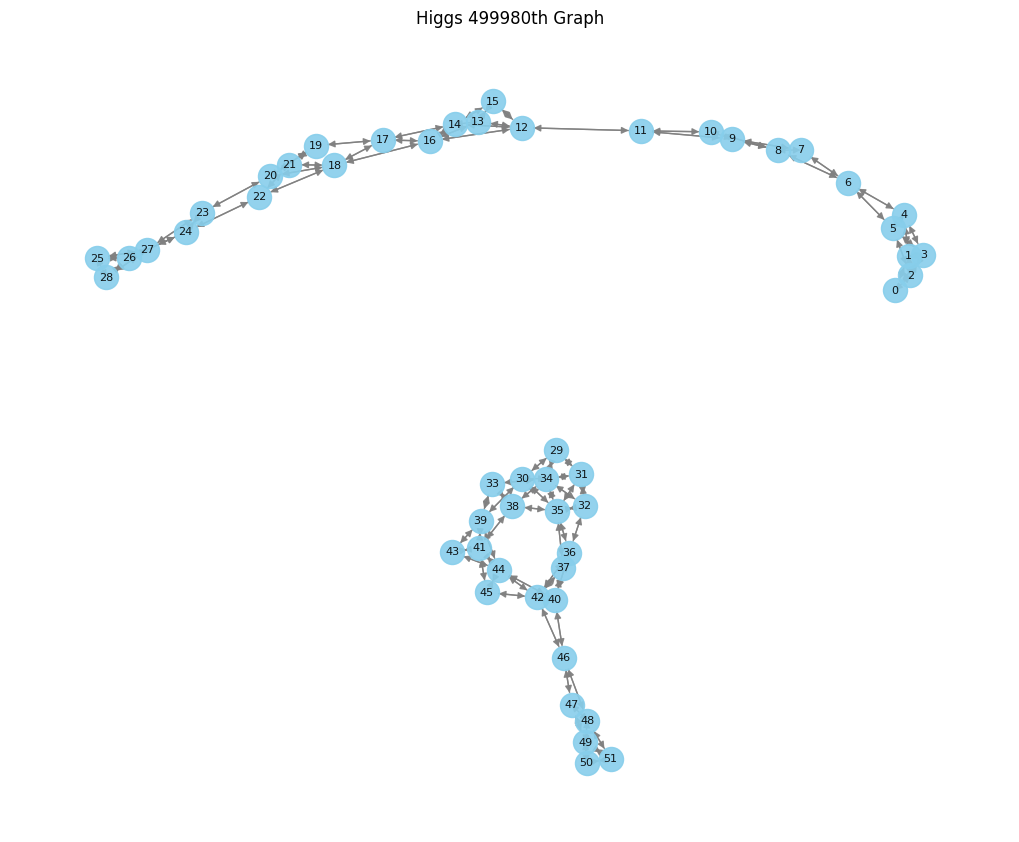

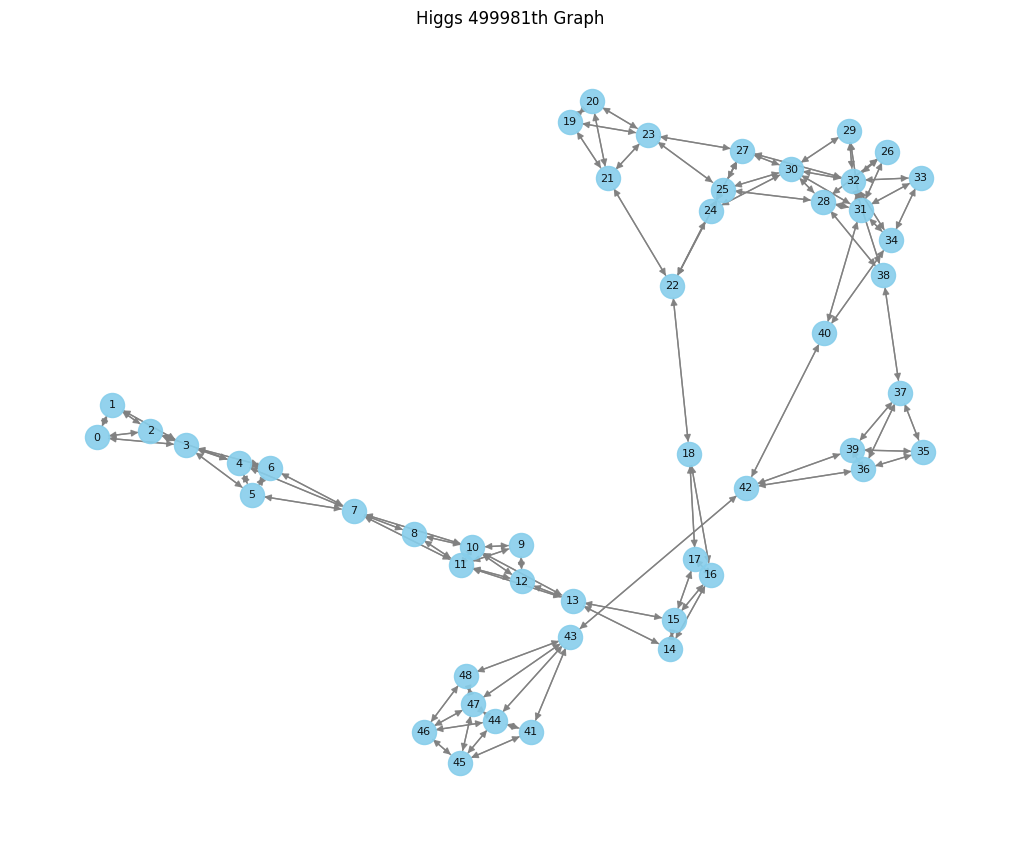

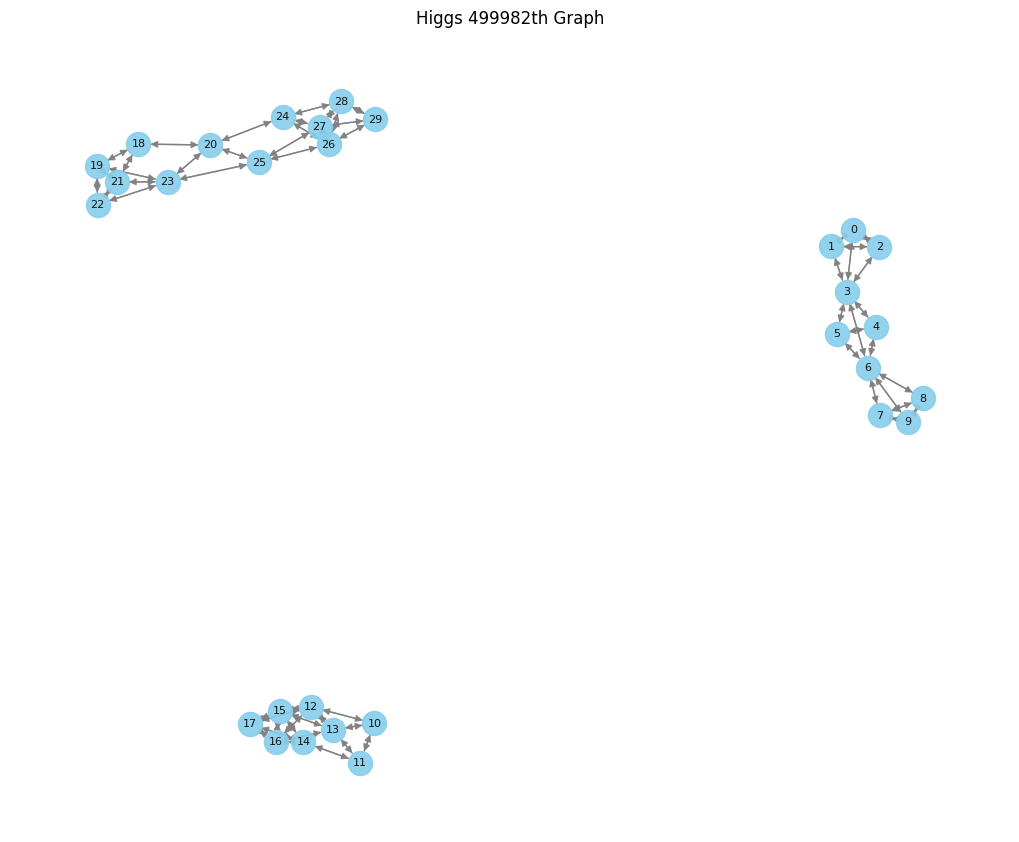

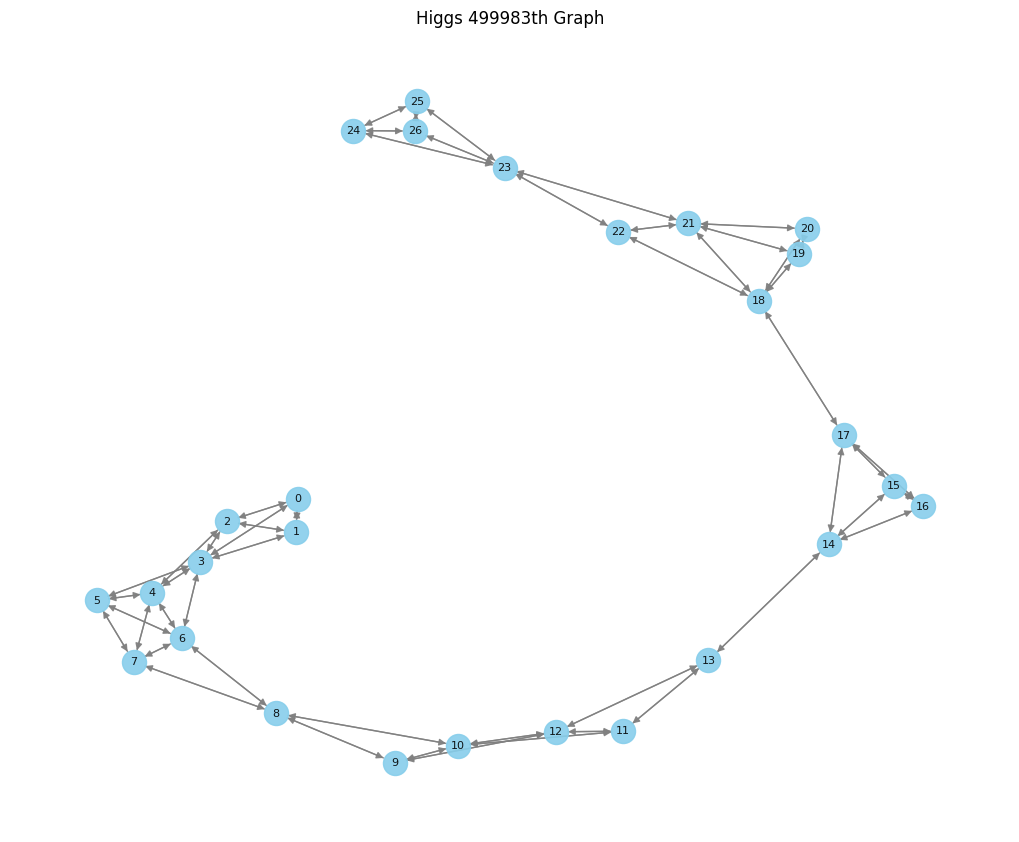

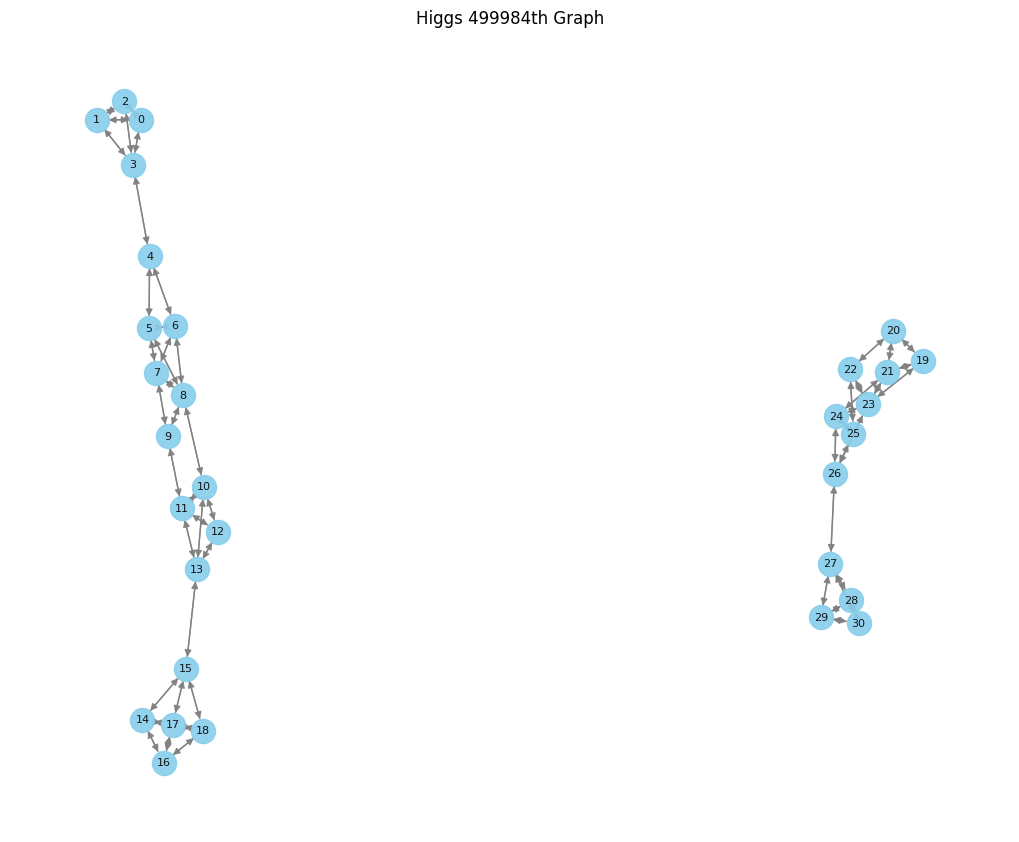

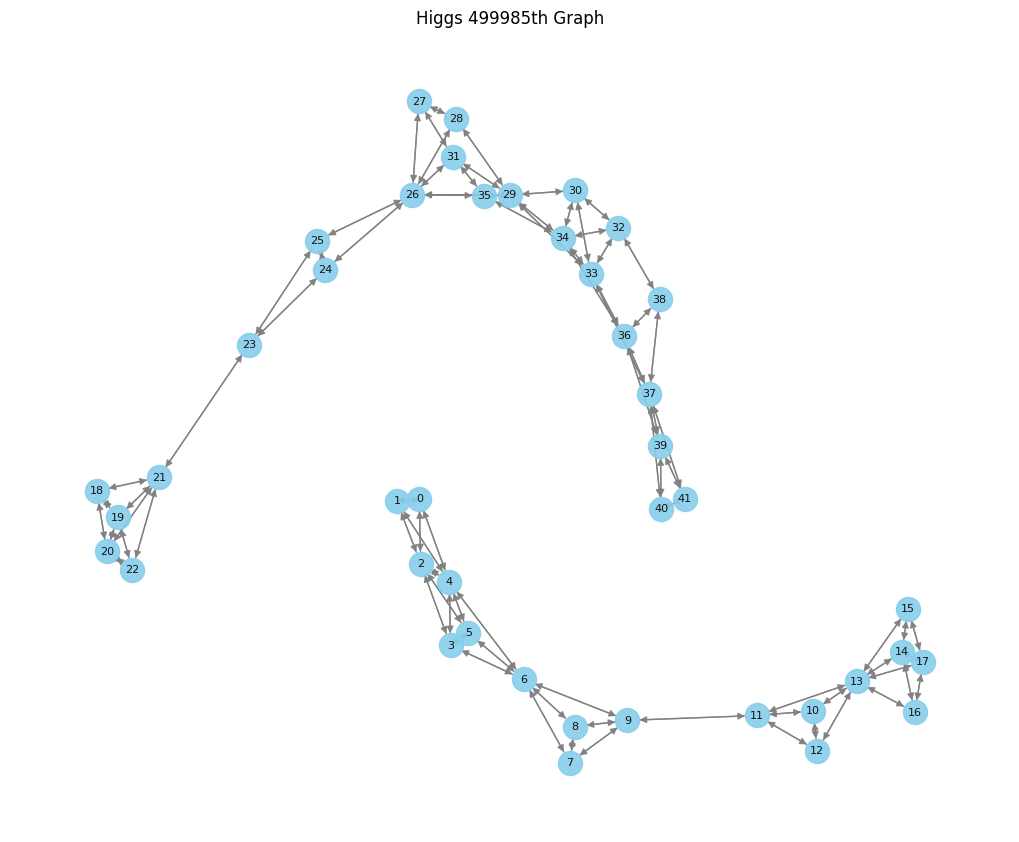

Vector file loaded successfully! Total number of graphs: 199994


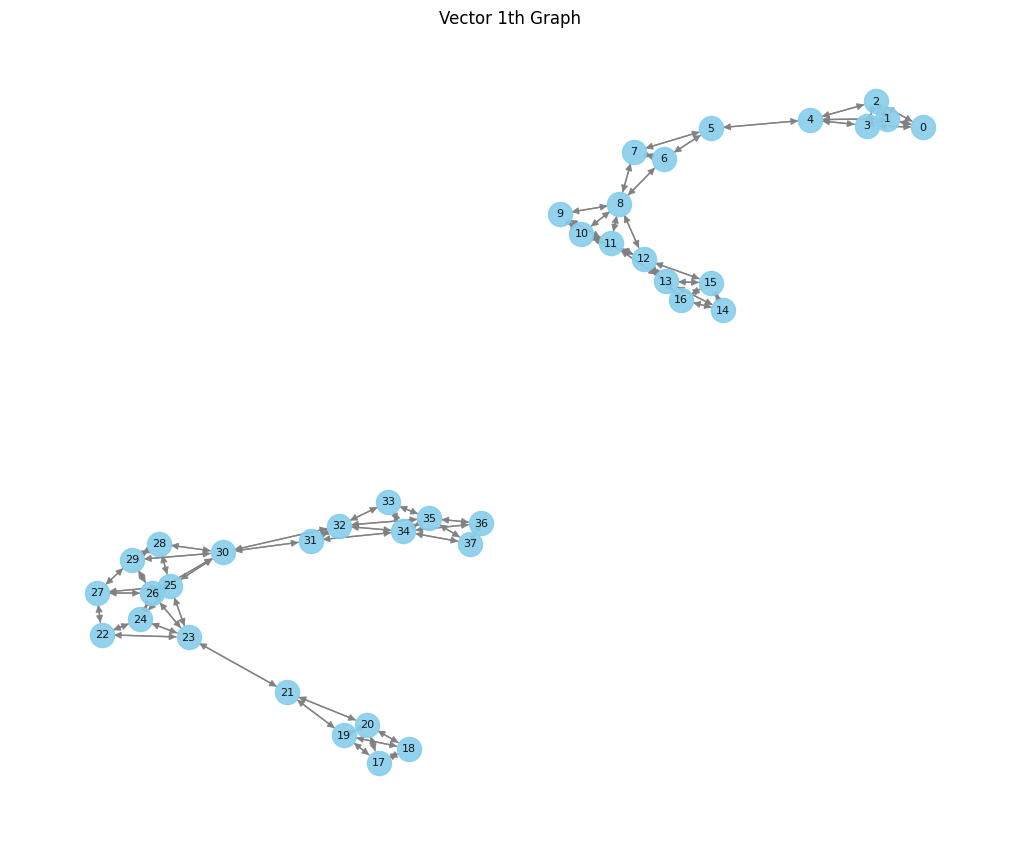

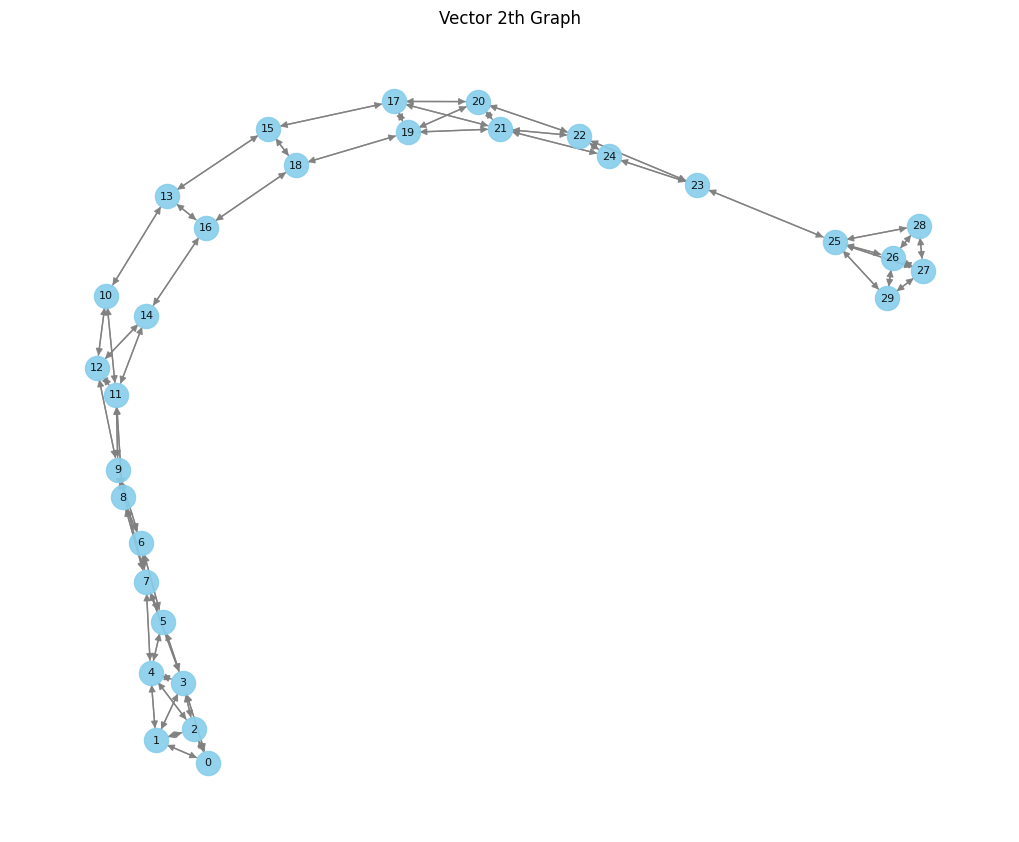

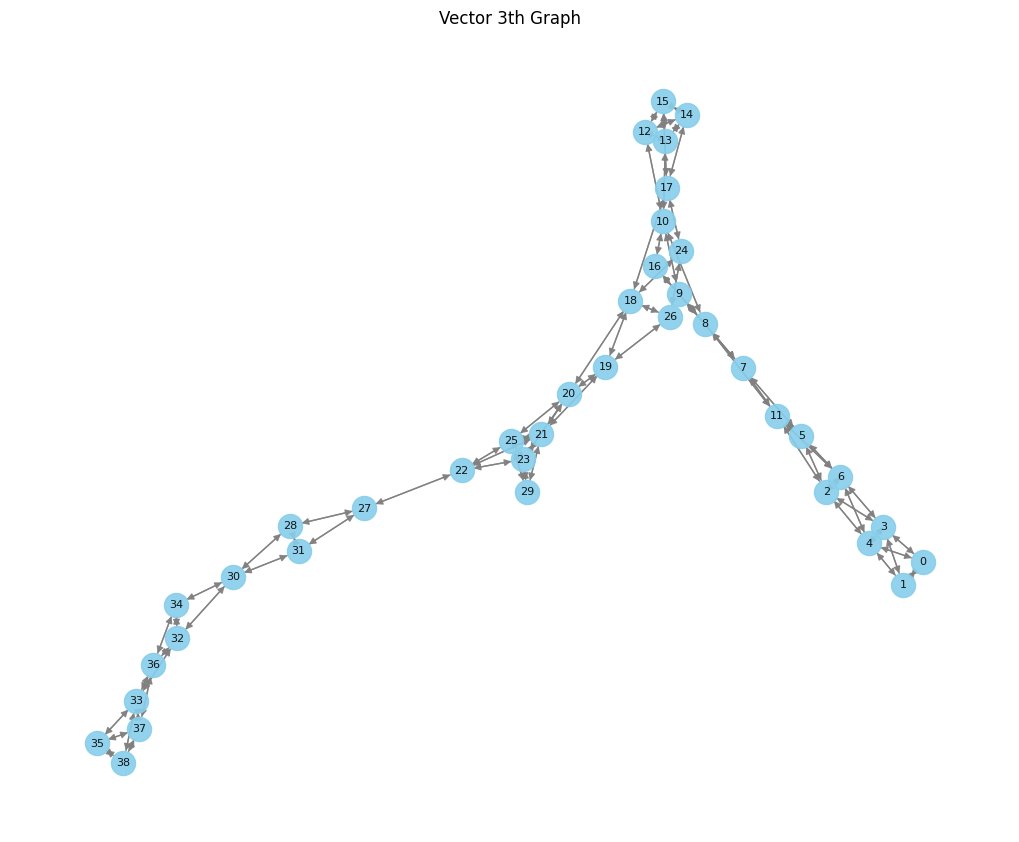

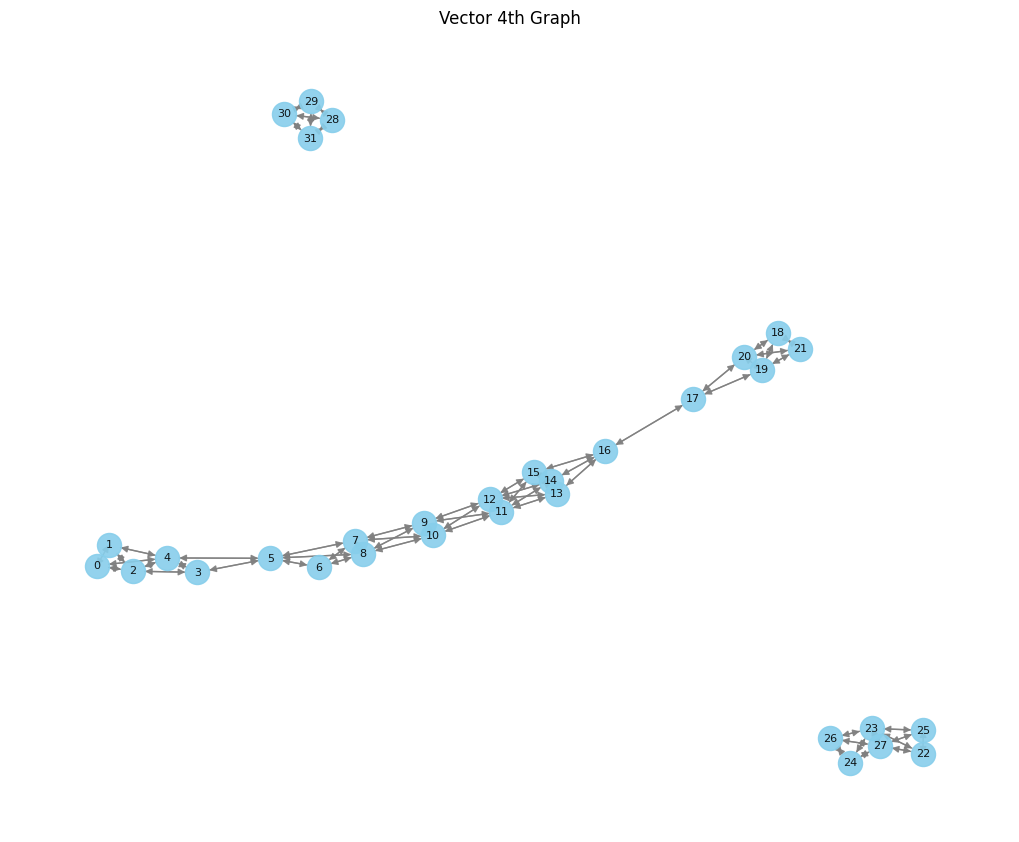

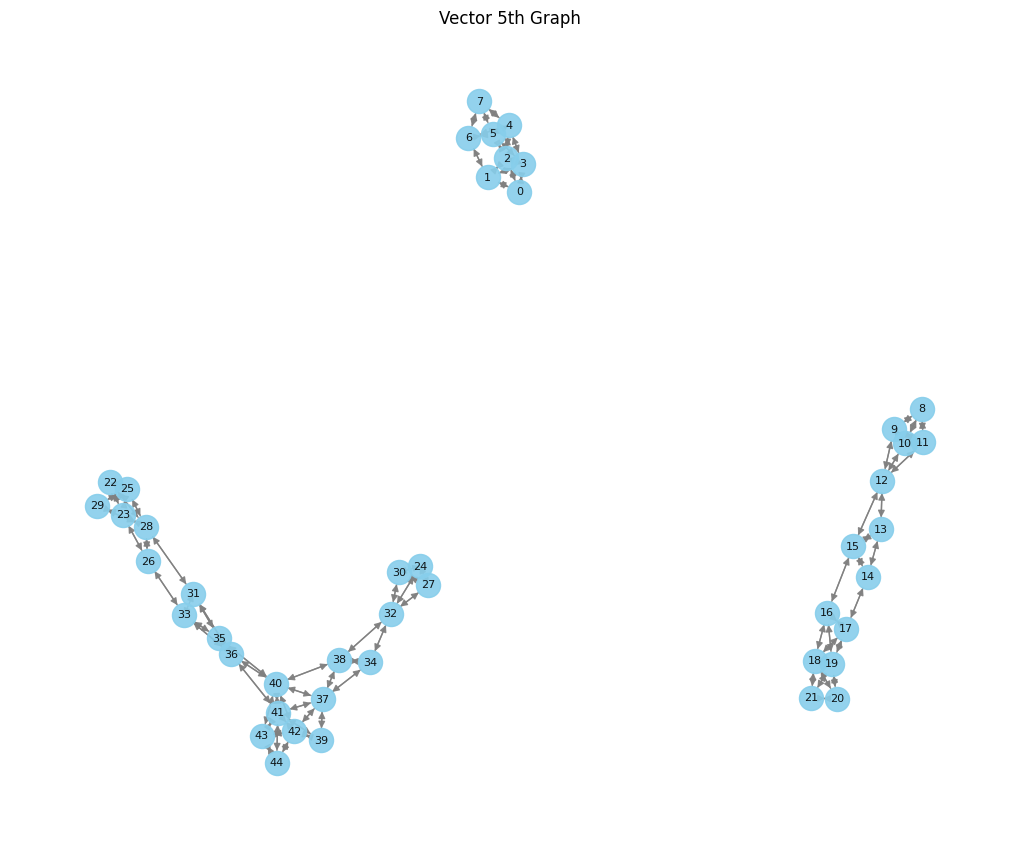

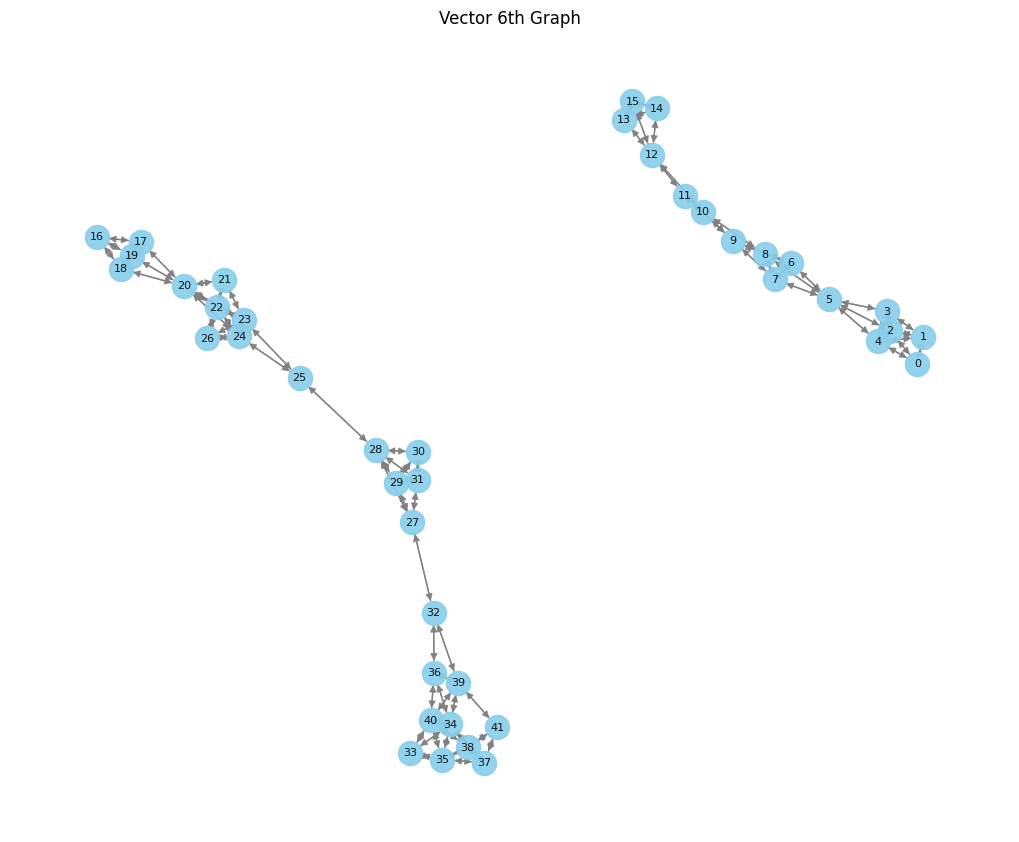

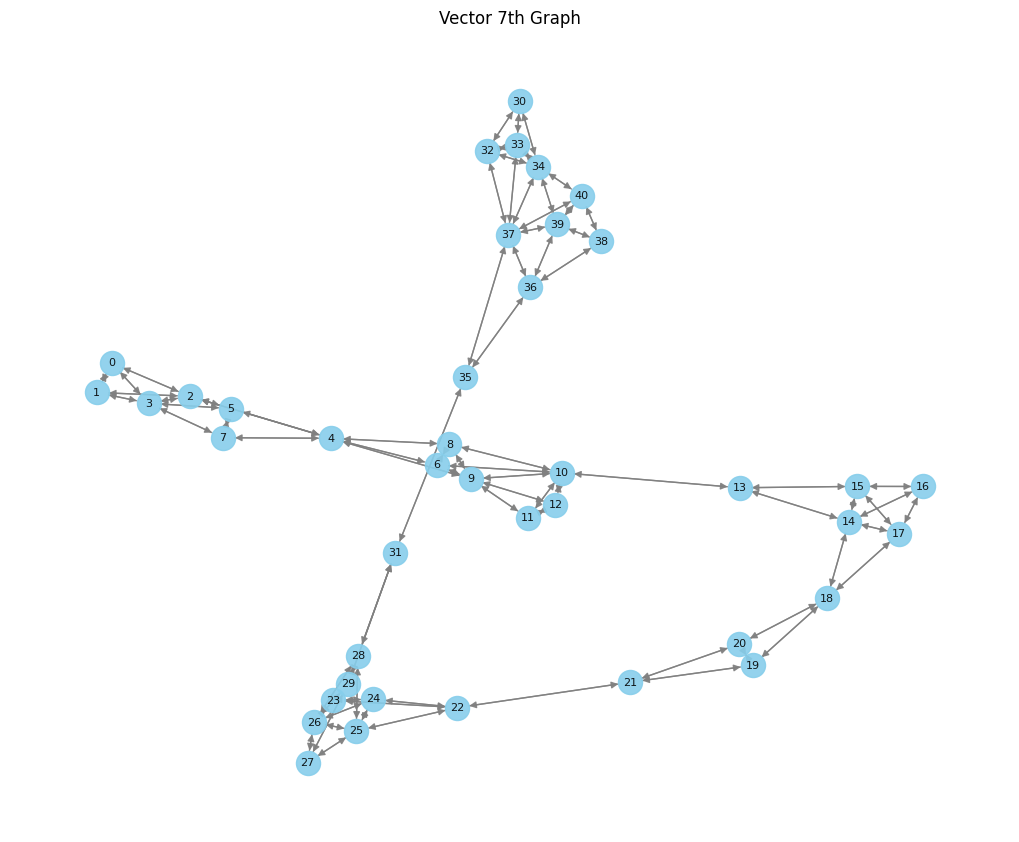

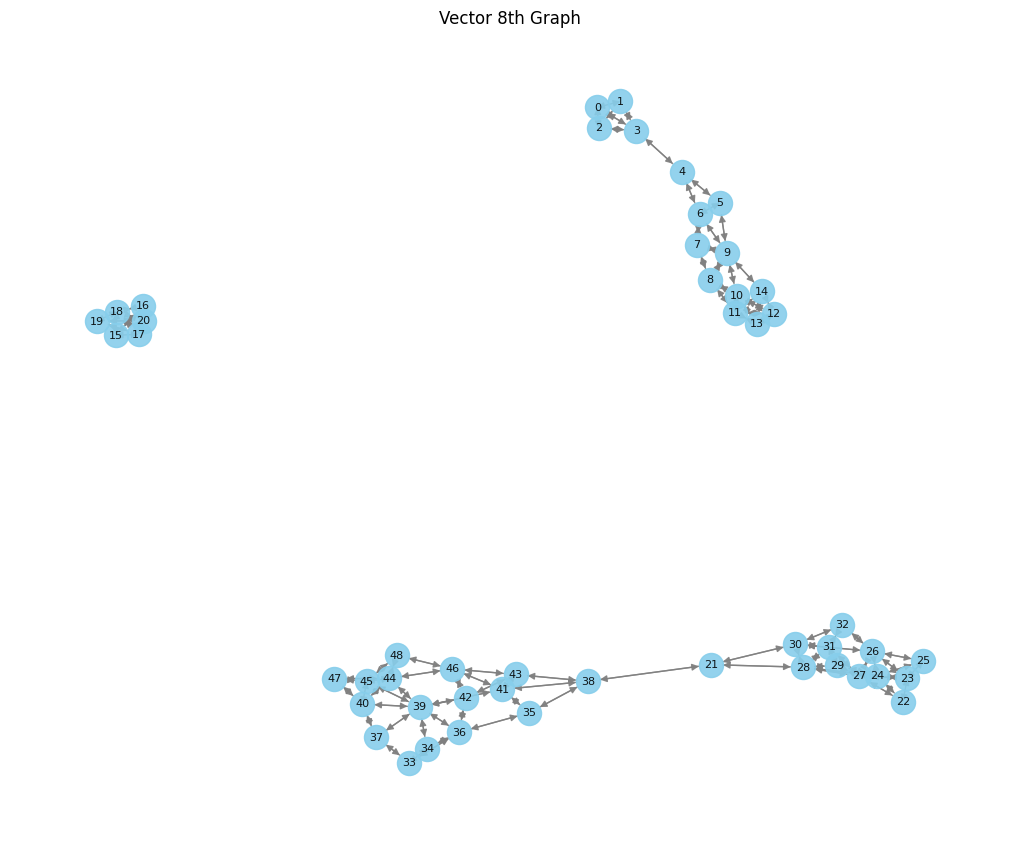

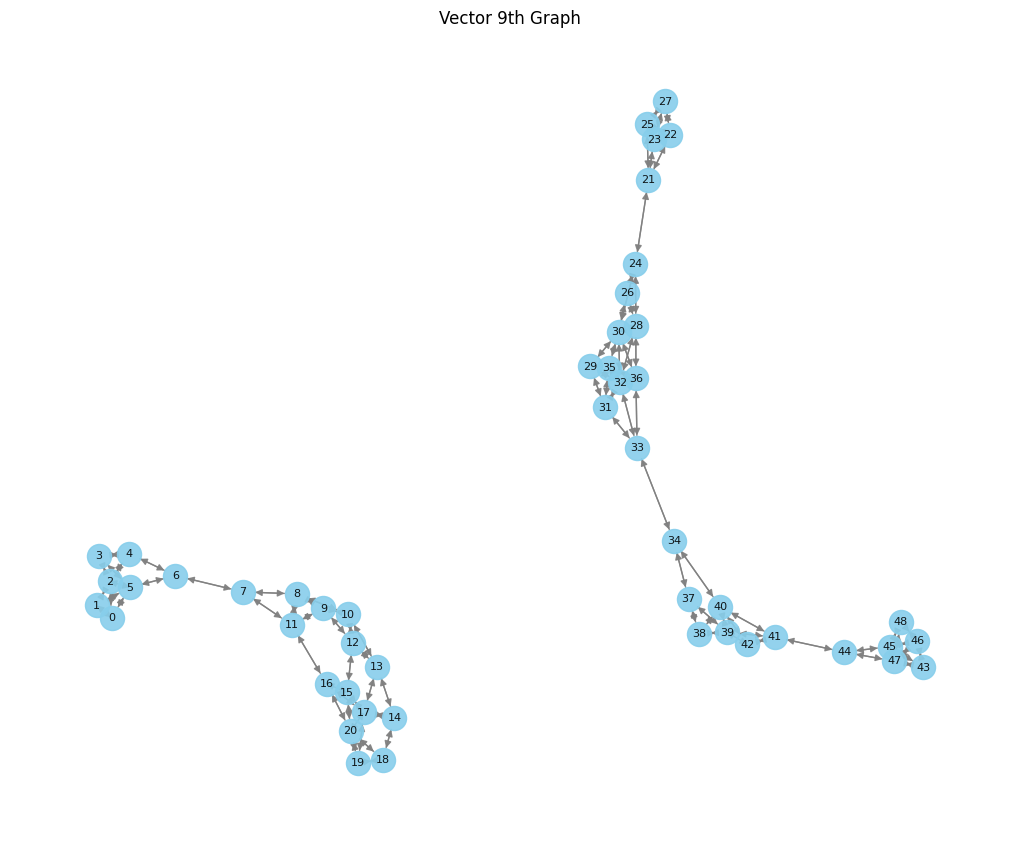

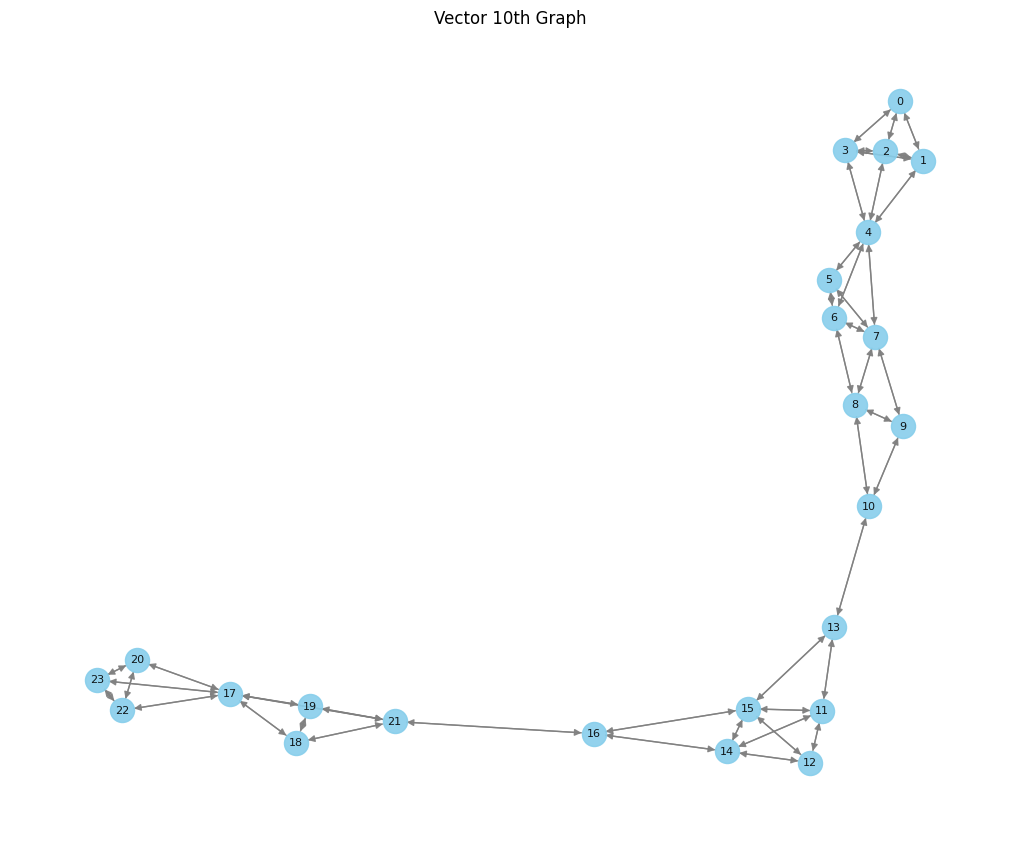

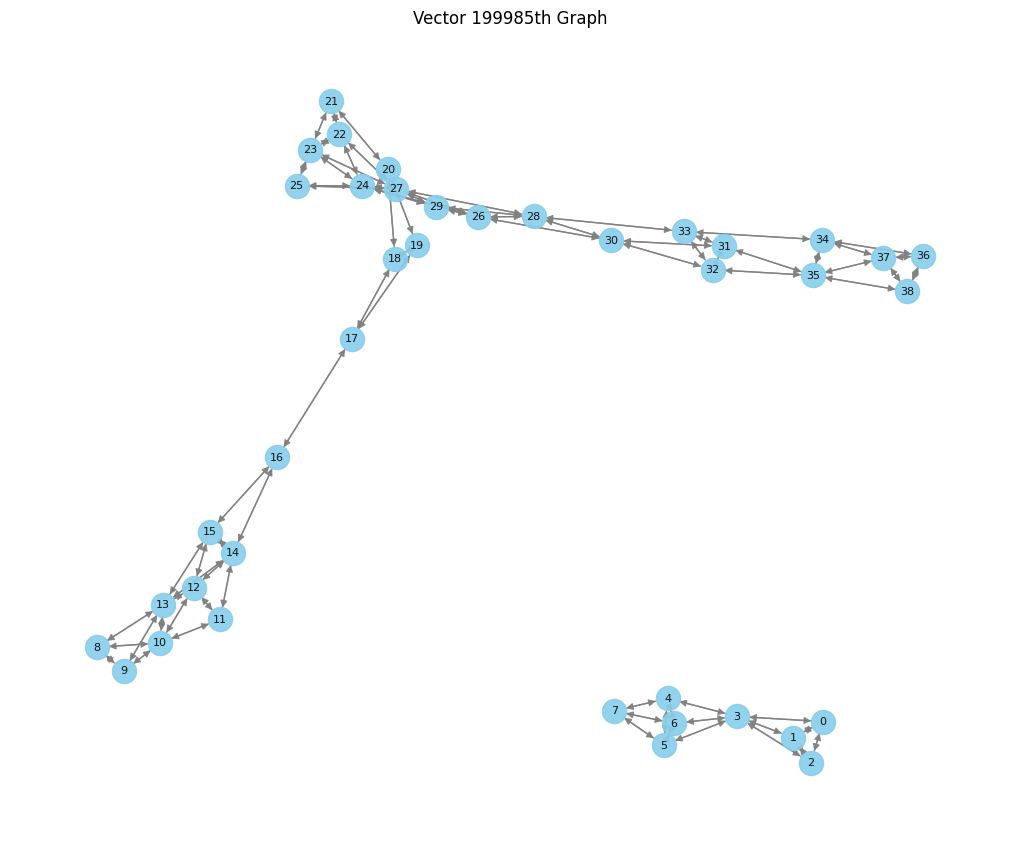

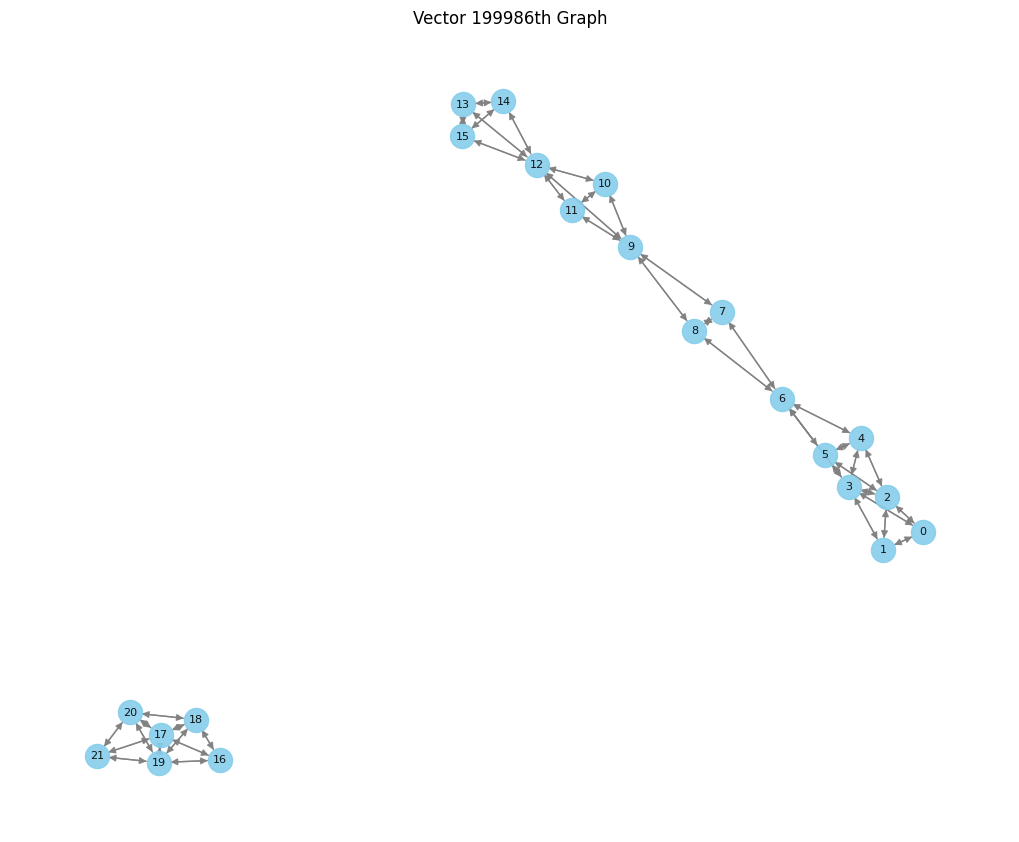

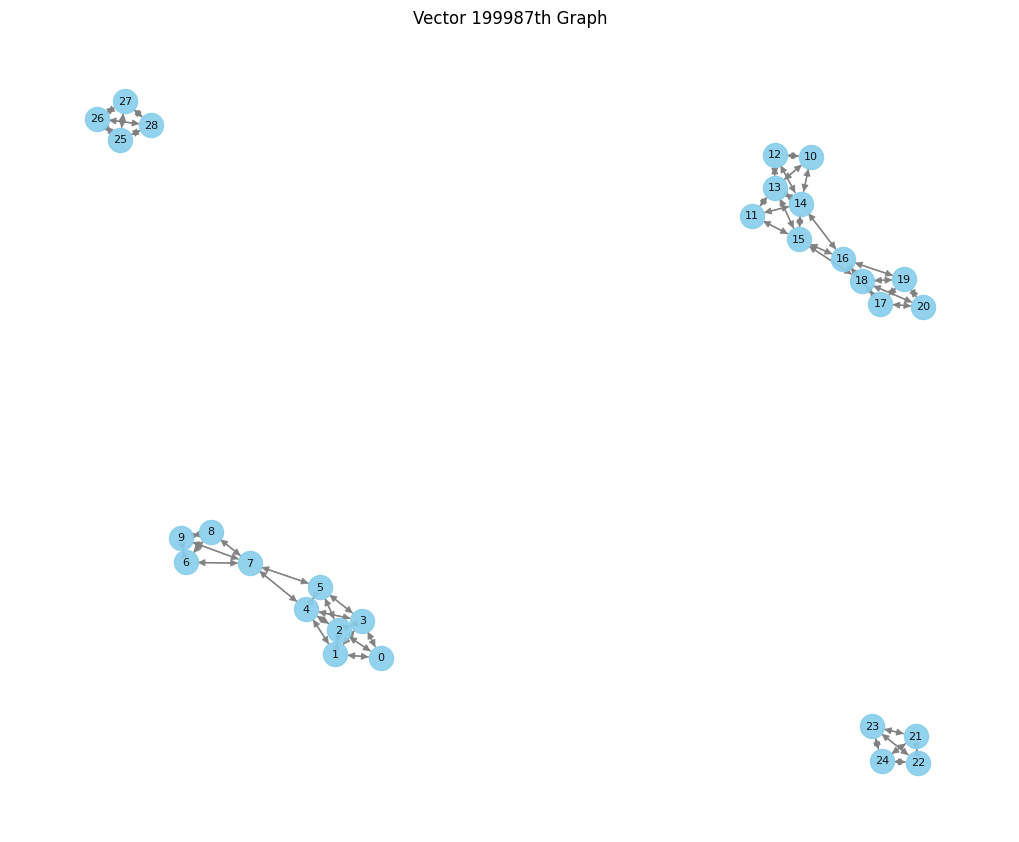

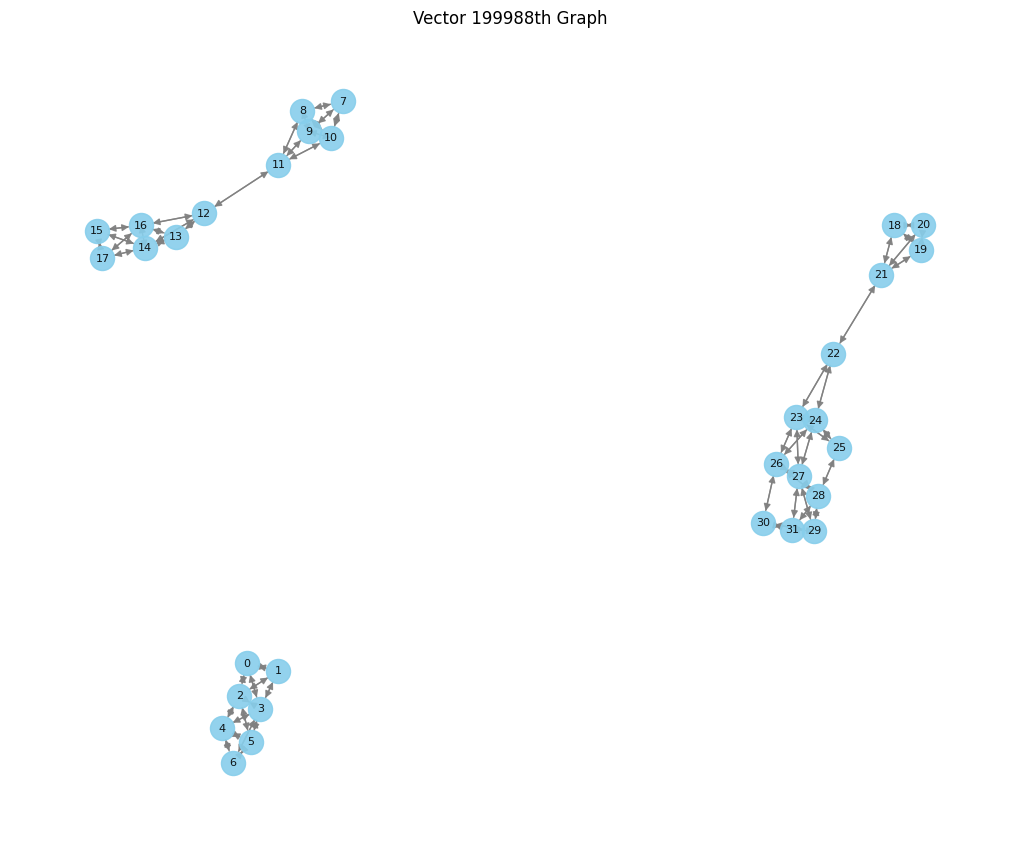

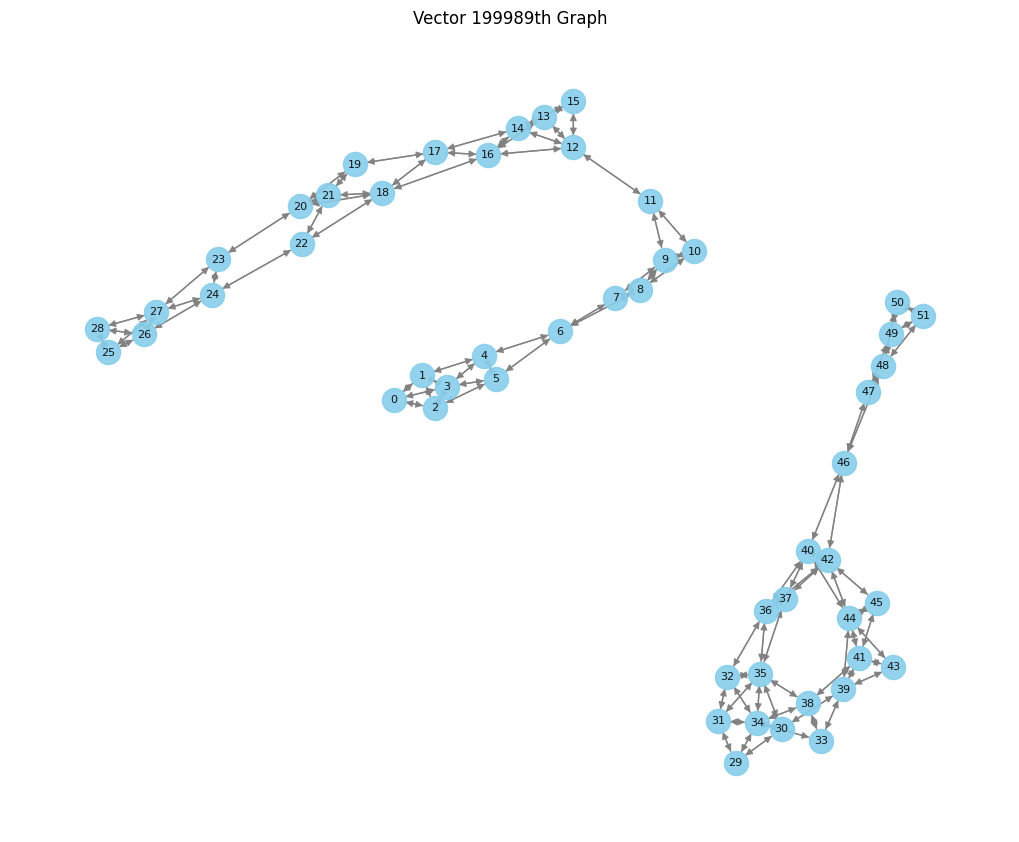

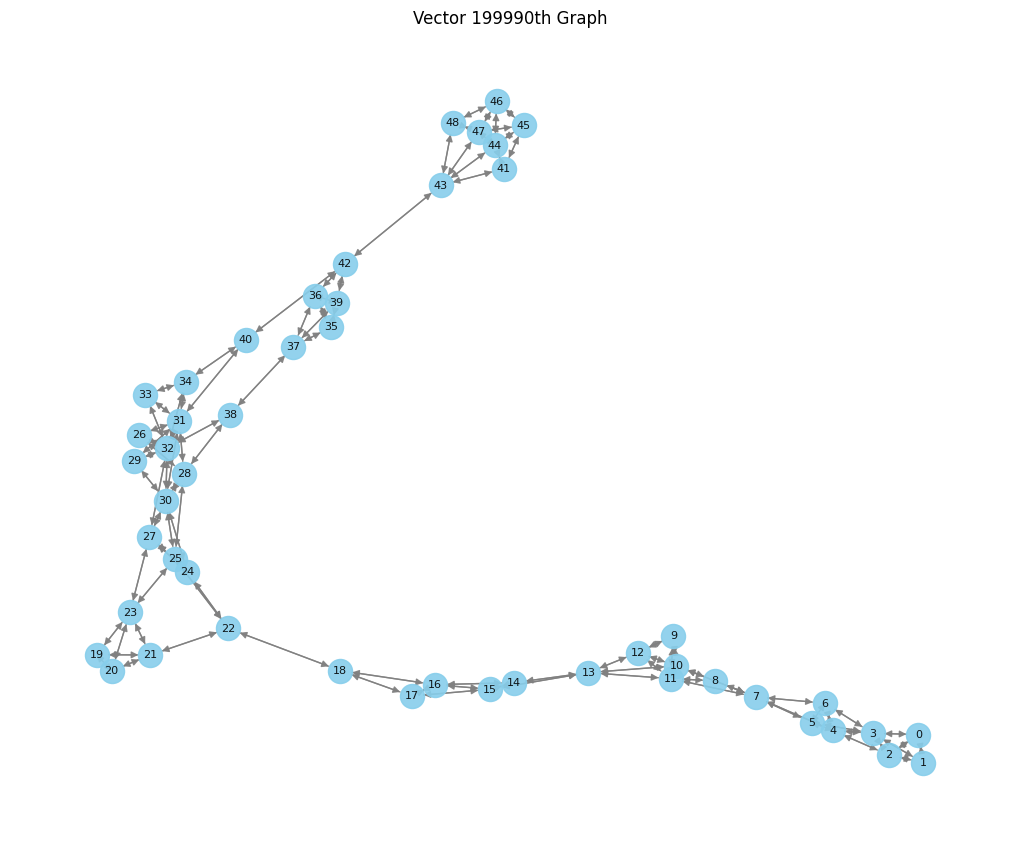

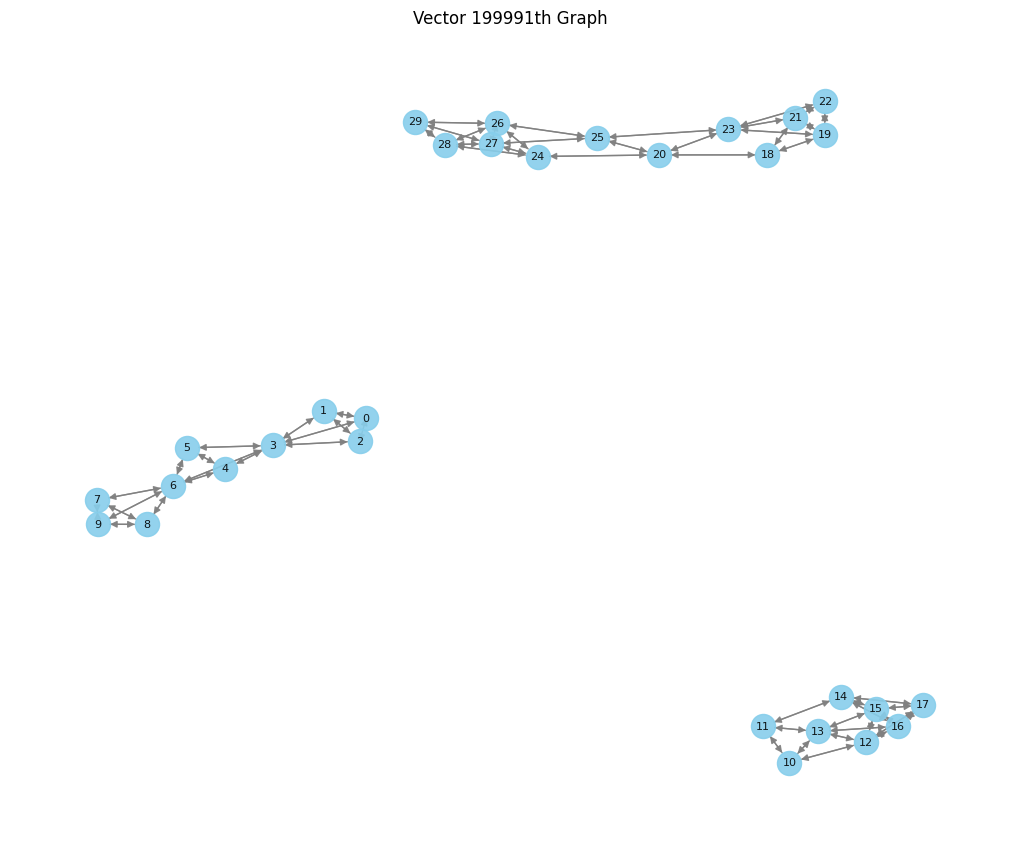

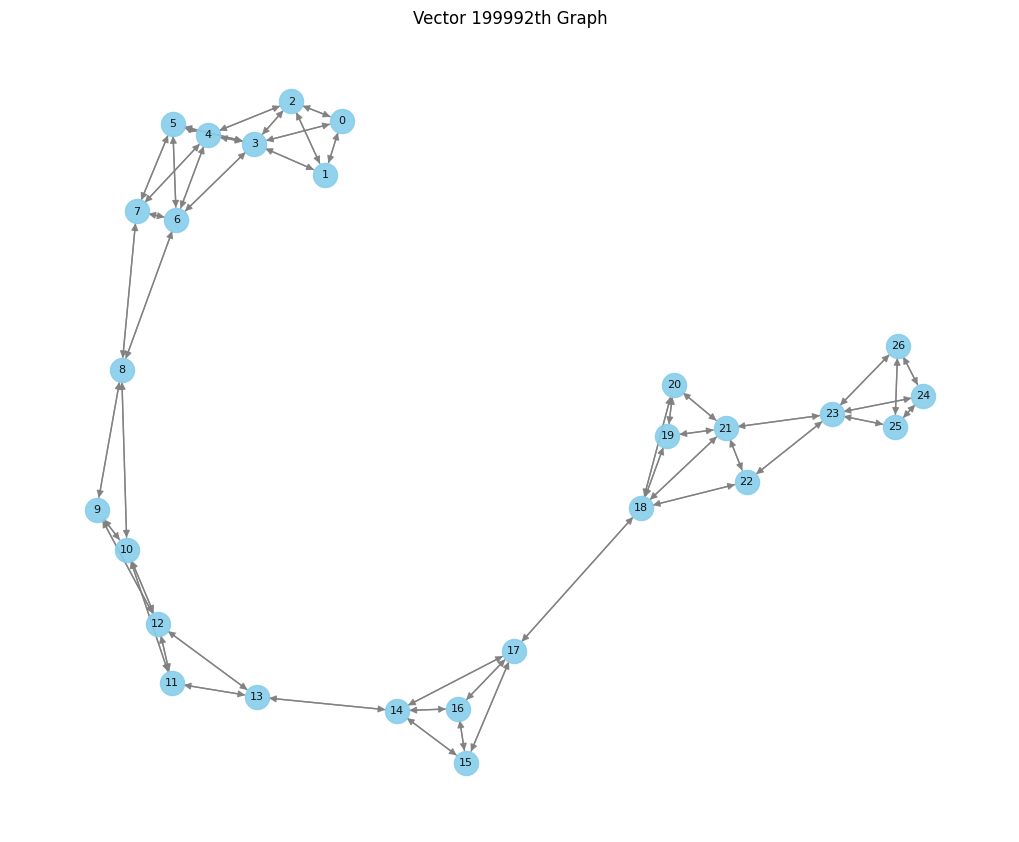

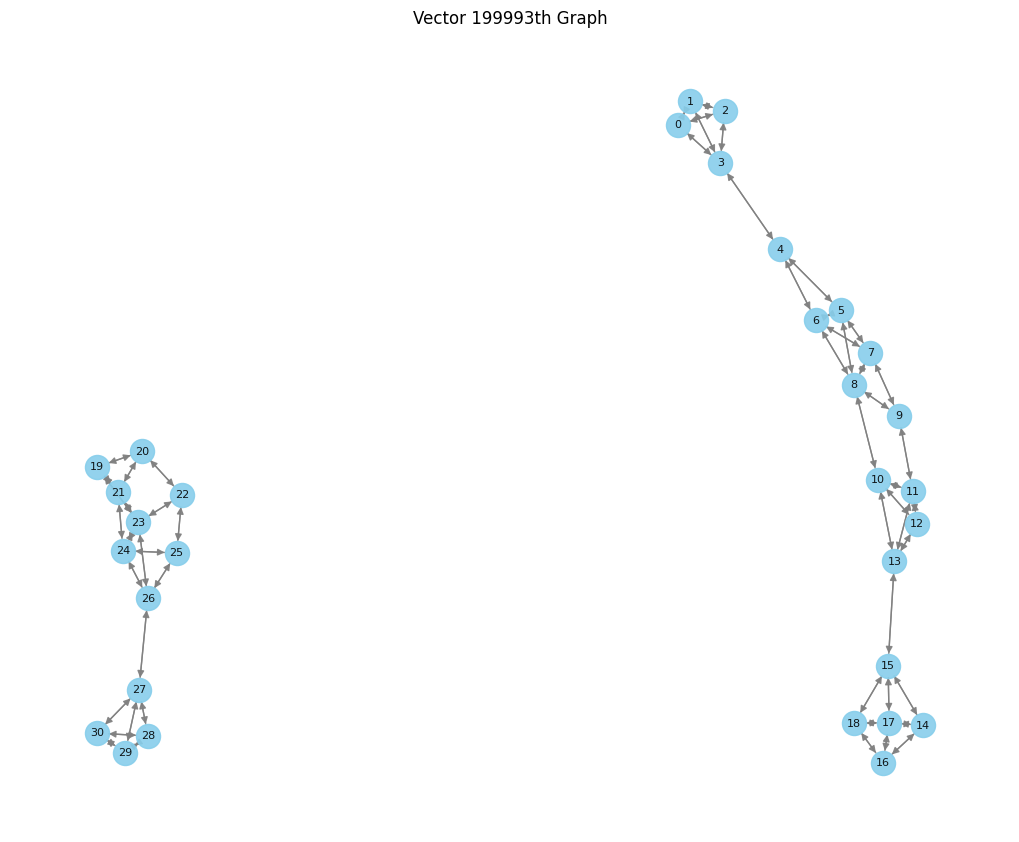

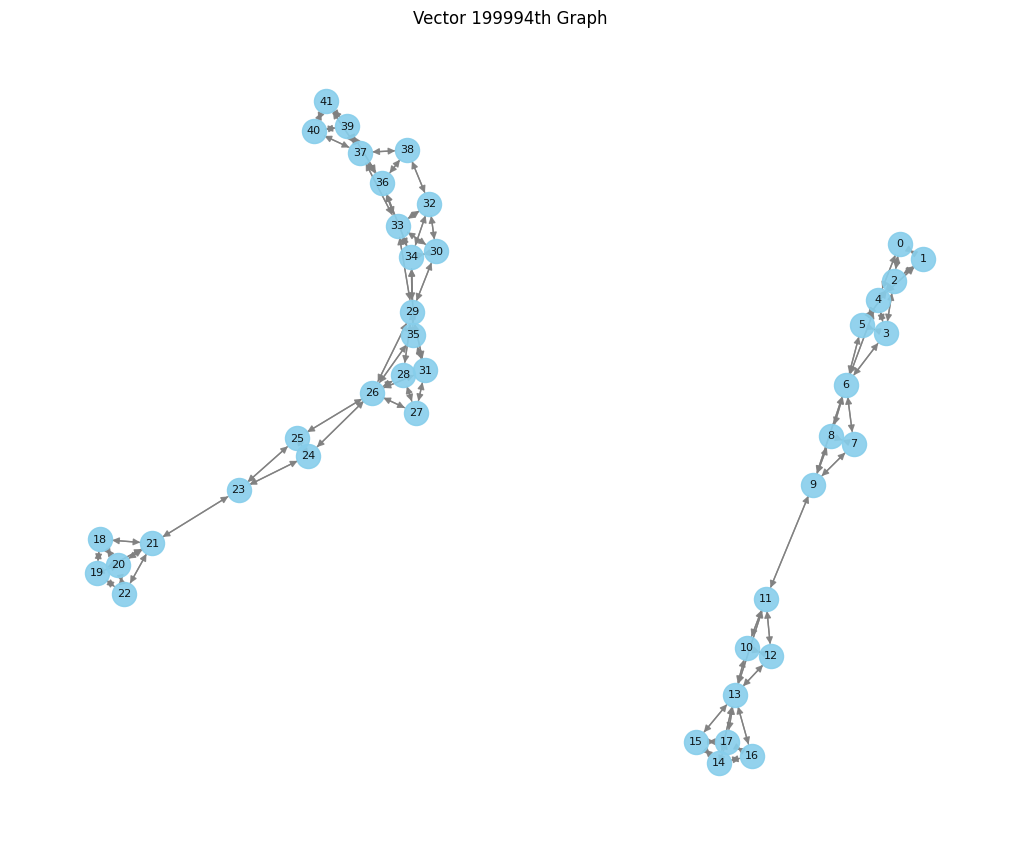

In [ ]:
# Load and visualize graphs for all jet types
def load_and_visualize_graphs(jet_category, file_name):
    file_path = f'./data/Multi Level Jet Tagging/{file_name}.pkl'
    try:
        with open(file_path, 'rb') as f:
            graphs = pickle.load(f)
        print(f"{jet_category} file loaded successfully! Total number of graphs: {len(graphs)}")
    except Exception as e:
        print(f"Failed to load the file {file_name}: {e}")
        return

    def visualize_graph_with_labels(graphs, indices, title_prefix, category):
        for idx in indices:
            g = graphs[idx]
            nx_graph = g.to_networkx()
            pos = nx.spring_layout(nx_graph)
            plt.figure(figsize=(10, 8))
            nx.draw(
                nx_graph, pos,
                with_labels=True,
                labels={node: node for node in nx_graph.nodes()},
                node_size=300,
                node_color="skyblue",
                font_size=8,
                font_color="black",
                edge_color="gray",
                alpha=0.9
            )
            plt.title(f"{category} {idx + 1}th Graph")
            plt.show()

    first_10_indices = list(range(min(10, len(graphs))))
    last_10_indices = list(range(max(0, len(graphs) - 10), len(graphs)))
    visualize_graph_with_labels(graphs, first_10_indices, "First 10", jet_category)
    visualize_graph_with_labels(graphs, last_10_indices, "Last 10", jet_category)

# Define jet categories and their corresponding file names
jet_categories = {
    "Higgs": "Emitter-Higgs",
    "Vector": "Emitter-Vector",
    "Top": "Emitter-Top",
    "QCD": "Emitter-QCD"
}

# Load and visualize graphs for each jet category
for category, file_name in jet_categories.items():
    load_and_visualize_graphs(category, file_name)

print("Visualization complete for all jet categories.")